In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import defaultdict
import pickle
import numpy as np

# sns.set_style("whitegrid")
sns.set(style={'style': "whitegrid", 'axes.grid' : False}, font_scale=1.5)

In [2]:
import os
# os.chdir('../')

In [3]:
os.getcwd()

'C:\\Users\\isvandroffelaa\\Documents\\model\\coarsening\\analysis'

In [4]:
pct = 0.95

In [5]:
with open(f'./cleaned_data/num_nodes_orig.pkl', 'rb') as f:
    num_nodes_orig = pickle.load(f)
    
with open(f'./cleaned_data/crosseval_original.pkl', 'rb') as f:
    cross_eval_orig = pickle.load(f)
    
with open(f'./cleaned_data/timing_results.pkl', 'rb') as f:
    time_per_nfe = pickle.load(f)
    
results_orig = pd.DataFrame()
results_best_orig = pd.DataFrame()
results_best_orig_across_seeds = pd.DataFrame()
for SSR in ['without_SSR', 'with_SSR']:
# for SSR in ['without_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        best_found_score_across_seeds = 0
        for seed in range(10):
            results_ = pd.read_csv(f'../HPC_results/{SSR}/original/convergence_original_{city}_seed{seed}.csv')
            results_['SSR'] = SSR
            results_['city'] = city
            results_['seed'] = seed
            results_['num nodes'] = num_nodes_orig[city]
            results_['node reduction (%)'] = (1-(num_nodes_orig[city] / num_nodes_orig[city])) * 100
            results_['cross eval score'] = max(results_['best_score'])/1000
            results_['% of original score'] = 100
            results_orig = pd.concat([results_orig, results_])
            
            results_dict = {}
            best_score = max(results_['best_score'])
            # print(city, seed, min(results_[results_.best_score == best_score]['nfe']))
            nfe_of_best_score = min(results_[results_.best_score >= (pct*best_score)]['nfe'])
            results_dict['SSR'] = [SSR]
            results_dict['city'] = [city]
            results_dict['num nodes'] = num_nodes_orig[city]
            results_dict['node reduction (%)'] = (1-(num_nodes_orig[city] / num_nodes_orig[city])) * 100
            results_dict['cross eval score'] = [best_score/1000]
            results_dict['% of original score'] = 100
            results_dict['seed'] = [seed]
            results_dict['best_score'] = [best_score]
            results_dict['nfe_of_best'] = [nfe_of_best_score]
            results_dict['time_to_best'] = [nfe_of_best_score * time_per_nfe['original', city, num_nodes_orig[city]] / 1000]
            results_per_file = pd.DataFrame.from_dict(results_dict)
            results_best_orig = pd.concat([results_best_orig, results_per_file])
            
            if cross_eval_orig[city, seed] >= best_found_score_across_seeds:
                best_found_score_across_seeds = cross_eval_orig[city, seed]
                results_best_orig_across_seeds_ = results_per_file.copy()
            
        
        results_best_orig_across_seeds = pd.concat([results_best_orig_across_seeds, results_best_orig_across_seeds_])
     
results_orig['approach'] = 'original'
results_best_orig['approach'] = 'original'
results_best_orig_across_seeds['approach'] = 'original'

earliest_nfes = []
earliest_nfes_ = []

for SSR in ['without_SSR', 'with_SSR']:
# for SSR in ['without_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        results_best_orig_city = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')
        earliest_nfes.extend([min(results_best_orig_city[results_best_orig_city.best_score >= (pct*max(results_best_orig_city['best_score']))]['nfe_of_best'])]*10)
        earliest_nfes_.extend([min(results_best_orig_city[results_best_orig_city.best_score >= (pct*max(results_best_orig_city['best_score']))]['nfe_of_best'])])
        # print(min(results_best_orig_city[results_best_orig_city.best_score >= (pct*max(results_best_orig_city['best_score']))]))
results_best_orig['earliest_nfe_of_95'] = earliest_nfes
results_best_orig_across_seeds['earliest_nfe_of_95'] = earliest_nfes_

In [6]:
num_nodes_orig

{'Winterswijk': 1926,
 'Manhattan': 2533,
 'Utrecht': 4557,
 'Amsterdam': 3241,
 'Rotterdam': 7108}

In [7]:
orig_scores_best = {}
for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
    orig_scores_best[city] = max(results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score'])

orig_scores_best

{'Winterswijk': 0.74,
 'Manhattan': 0.899,
 'Utrecht': 0.651,
 'Amsterdam': 0.955,
 'Rotterdam': 0.374}

In [8]:
# with open(f'./cleaned_data/num_nodes_pruning.pkl', 'rb') as f:
#     num_nodes = pickle.load(f)
#     
# with open(f'./cleaned_data/crosseval_pruning.pkl', 'rb') as f:
#     cross_eval = pickle.load(f)
# 
# max_iter_dict = {
#     'Winterswijk': 5,
#     'Manhattan': 1,
#     'Utrecht': 6, 
#     'Amsterdam': 6, 
#     'Rotterdam': 7
# }
# 
# results_pruning = pd.DataFrame()
# results_best_pruning = pd.DataFrame()
# results_best_pruning_across_seeds = pd.DataFrame()
# for SSR in ['without_SSR', 'with_SSR']:
#     for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
#         for iteration in range(max_iter_dict[city]):
#             best_found_score_across_seeds = 0
#             for seed in range(10):
#                 # try:
#                 results_ = pd.read_csv(f'../HPC_results/{SSR}/pruning/convergence_pruning_{city}_iter{iteration}_seed{seed}.csv')
#                 results_['SSR'] = SSR
#                 results_['city'] = city
#                 results_['seed'] = seed
#                 results_['num_nodes'] = num_nodes[city, iteration]
#                 results_['node reduction (%)'] = (1-(num_nodes[city, iteration] / num_nodes_orig[city])) * 100
#                 results_['cross eval score'] = cross_eval[SSR, city, iteration, seed]
#                 results_['% of original score'] = (cross_eval[SSR, city, iteration, seed] / orig_scores_best[city]) * 100
#                 results_pruning = pd.concat([results_pruning, results_])
#                 
#                 results_dict = {}
#                 best_score = max(results_['best_score'])
#                 # print(city, seed, min(results_[results_.best_score == best_score]['nfe']))
#                 nfe_of_best_score = min(results_[results_.best_score >= (pct*best_score)]['nfe'])
#                 results_dict['SSR'] = [SSR]
#                 results_dict['city'] = [city]
#                 results_dict['num_nodes'] = num_nodes[city, iteration]
#                 results_dict['node reduction (%)'] = (1-(num_nodes[city, iteration] / num_nodes_orig[city])) * 100
#                 results_dict['cross eval score'] = cross_eval[SSR, city, iteration, seed]
#                 results_dict['% of original score'] = (cross_eval[SSR, city, iteration, seed] / orig_scores_best[city]) * 100
#                 results_dict['seed'] = [seed]
#                 results_dict['best_score'] = [best_score]
#                 results_dict['nfe_of_best'] = [nfe_of_best_score]
#                 results_dict['time_to_best'] = [nfe_of_best_score * time_per_nfe['pruning', city, num_nodes[city, max_iter_dict[city]-1]] / 1000]
#                 results_per_file = pd.DataFrame.from_dict(results_dict)
#                 results_best_pruning = pd.concat([results_best_pruning, results_per_file])
#                 
#                 if cross_eval[SSR, city, iteration, seed] >= best_found_score_across_seeds:
#                     best_found_score_across_seeds = cross_eval[SSR, city, iteration, seed]
#                     results_best_pruning_across_seeds_ = results_per_file.copy()
#                 # except:
#                 #     print(SSR, city, iteration, seed)
#                 #     results_dict = {}
#                 #     results_dict['SSR'] = [SSR]
#                 #     results_per_file = pd.DataFrame.from_dict(results_dict)
#                 #     results_best_pruning = pd.concat([results_best_pruning, results_per_file])
#             
#             results_best_pruning_across_seeds = pd.concat([results_best_pruning_across_seeds, results_best_pruning_across_seeds_])
#                 
# results_pruning['approach'] = 'pruning'
# results_best_pruning['approach'] = 'pruning'
# results_best_pruning_across_seeds['approach'] = 'pruning'
# 
# earliest_nfes = []
# earliest_nfes_ = []
# 
# for SSR in ['without_SSR', 'with_SSR']:
#     for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
#         for iteration in range(max_iter_dict[city]):
#             results_best_pruning_city = results_best_pruning.query(f'SSR == "{SSR}" &  city == "{city}" & num_nodes == {num_nodes[city, iteration]}')
#             earliest_nfes.extend([min(results_best_pruning_city[results_best_pruning_city.best_score >= (pct*max(results_best_pruning_city['best_score']))]['nfe_of_best'])]*10)
#             earliest_nfes_.extend([min(results_best_pruning_city[results_best_pruning_city.best_score >= (pct*max(results_best_pruning_city['best_score']))]['nfe_of_best'])])
#         # print(min(results_best_orig_city[results_best_orig_city.best_score >= (pct*max(results_best_orig_city['best_score']))]))
# results_best_pruning['earliest_nfe_of_95'] = earliest_nfes
# results_best_pruning_across_seeds['earliest_nfe_of_95'] = earliest_nfes_

In [9]:
with open(f'./cleaned_data/num_nodes_pruning.pkl', 'rb') as f:
    num_nodes = pickle.load(f)
    
with open(f'./cleaned_data/crosseval_pruning.pkl', 'rb') as f:
    cross_eval = pickle.load(f)

max_iter_dict = {
    'Winterswijk': 5,
    'Manhattan': 1,
    'Utrecht': 6, 
    'Amsterdam': 6, 
    'Rotterdam': 7
}

results_pruning = pd.DataFrame()
results_best_pruning = pd.DataFrame()
results_best_pruning_across_seeds = pd.DataFrame()
for SSR in ['without_SSR', 'with_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        # for iteration in range(max_iter_dict[city]):
        best_found_score_across_seeds = 0
        for seed in range(10):
            # try:
            iteration = max_iter_dict[city]-1
            results_ = pd.read_csv(f'../HPC_results/{SSR}/pruning/convergence_pruning_{city}_iter{iteration}_seed{seed}.csv')
            results_['SSR'] = SSR
            results_['city'] = city
            results_['seed'] = seed
            results_['num_nodes'] = num_nodes[city, iteration]
            results_['node reduction (%)'] = (1-(num_nodes[city, iteration] / num_nodes_orig[city])) * 100
            results_['cross eval score'] = cross_eval[SSR, city, iteration, seed]
            results_['% of original score'] = (cross_eval[SSR, city, iteration, seed] / orig_scores_best[city]) * 100
            results_pruning = pd.concat([results_pruning, results_])
            
            results_dict = {}
            best_score = max(results_['best_score'])
            # print(city, seed, min(results_[results_.best_score == best_score]['nfe']))
            nfe_of_best_score = min(results_[results_.best_score >= (pct*best_score)]['nfe'])
            results_dict['SSR'] = [SSR]
            results_dict['city'] = [city]
            results_dict['num_nodes'] = num_nodes[city, iteration]
            results_dict['node reduction (%)'] = (1-(num_nodes[city, iteration] / num_nodes_orig[city])) * 100
            results_dict['cross eval score'] = cross_eval[SSR, city, iteration, seed]
            results_dict['% of original score'] = (cross_eval[SSR, city, iteration, seed] / orig_scores_best[city]) * 100
            results_dict['seed'] = [seed]
            results_dict['best_score'] = [best_score]
            results_dict['nfe_of_best'] = [nfe_of_best_score]
            results_dict['time_to_best'] = [nfe_of_best_score * time_per_nfe['pruning', city, num_nodes[city, max_iter_dict[city]-1]] / 1000]
            results_per_file = pd.DataFrame.from_dict(results_dict)
            results_best_pruning = pd.concat([results_best_pruning, results_per_file])
            
            if cross_eval[SSR, city, iteration, seed] >= best_found_score_across_seeds:
                best_found_score_across_seeds = cross_eval[SSR, city, iteration, seed]
                results_best_pruning_across_seeds_ = results_per_file.copy()
            # except:
            #     print(SSR, city, iteration, seed)
            #     results_dict = {}
            #     results_dict['SSR'] = [SSR]
            #     results_per_file = pd.DataFrame.from_dict(results_dict)
            #     results_best_pruning = pd.concat([results_best_pruning, results_per_file])
        
        results_best_pruning_across_seeds = pd.concat([results_best_pruning_across_seeds, results_best_pruning_across_seeds_])
                
results_pruning['approach'] = 'pruning'
results_best_pruning['approach'] = 'pruning'
results_best_pruning_across_seeds['approach'] = 'pruning'

earliest_nfes = []
earliest_nfes_ = []

for SSR in ['without_SSR', 'with_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        # for iteration in range(max_iter_dict[city]):
        iteration = max_iter_dict[city]-1
        results_best_pruning_city = results_best_pruning.query(f'SSR == "{SSR}" &  city == "{city}" & num_nodes == {num_nodes[city, iteration]}')
        earliest_nfes.extend([min(results_best_pruning_city[results_best_pruning_city.best_score >= (pct*max(results_best_pruning_city['best_score']))]['nfe_of_best'])]*10)
        earliest_nfes_.extend([min(results_best_pruning_city[results_best_pruning_city.best_score >= (pct*max(results_best_pruning_city['best_score']))]['nfe_of_best'])])
        # print(min(results_best_orig_city[results_best_orig_city.best_score >= (pct*max(results_best_orig_city['best_score']))]))
results_best_pruning['earliest_nfe_of_95'] = earliest_nfes
results_best_pruning_across_seeds['earliest_nfe_of_95'] = earliest_nfes_

In [10]:
# results_best_pruning_across_seeds

In [11]:
with open(f'./cleaned_data/num_nodes_onthefly.pkl', 'rb') as f:
    num_nodes = pickle.load(f)

with open(f'./cleaned_data/crosseval_onthefly.pkl', 'rb') as f:
    cross_eval = pickle.load(f)

results_onthefly = pd.DataFrame()
results_best_onthefly = pd.DataFrame()
results_best_onthefly_across_seeds = pd.DataFrame()
# for SSR in ['without_SSR', 'with_SSR']:
SSR = 'without_SSR'
for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
    best_found_score_across_seeds = 0
    for seed in range(10):
        # try:
        results_ = pd.read_csv(f'../HPC_results/{SSR}/onthefly/convergence_onthefly_{city}_seed{seed}.csv')
        results_['SSR'] = SSR
        results_['city'] = city
        results_['seed'] = seed
        results_['num_nodes'] = num_nodes[city]
        results_['node reduction (%)'] = (1-(num_nodes[city] / num_nodes_orig[city])) * 100
        results_['cross eval score'] = cross_eval[SSR, city, seed]
        results_['% of original score'] = (cross_eval[SSR, city, seed] / orig_scores_best[city]) * 100
        results_onthefly = pd.concat([results_onthefly, results_])

        results_dict = {}
        best_score = max(results_['best_score'])
        # print(city, seed, min(results_[results_.best_score == best_score]['nfe']))
        nfe_of_best_score = min(results_[results_.best_score >= (pct*best_score)]['nfe'])
        results_dict['SSR'] = [SSR]
        results_dict['city'] = [city]
        results_dict['num_nodes'] = num_nodes[city]
        results_dict['node reduction (%)'] = (1-(num_nodes[city] / num_nodes_orig[city])) * 100
        results_dict['cross eval score'] = [best_score]
        results_dict['% of original score'] = (cross_eval[SSR, city, seed] / orig_scores_best[city]) * 100
        results_dict['seed'] = [seed]
        results_dict['best_score'] = [best_score]
        results_dict['nfe_of_best'] = [nfe_of_best_score]
        results_dict['time_to_best'] = [nfe_of_best_score * time_per_nfe['onthefly', city, num_nodes[city]] / 1000]
        results_per_file = pd.DataFrame.from_dict(results_dict)
        results_best_onthefly = pd.concat([results_best_onthefly, results_per_file])

        if cross_eval[SSR, city, seed] >= best_found_score_across_seeds:
            best_found_score_across_seeds = cross_eval[SSR, city, seed]
            results_best_onthefly_across_seeds_ = results_per_file.copy()
        # except:
        #     print(SSR, city, seed)
        #     results_dict = {}
        #     results_dict['SSR'] = [SSR]
        #     results_per_file = pd.DataFrame.from_dict(results_dict)
        #     results_best_onthefly = pd.concat([results_best_onthefly, results_per_file])

    results_best_onthefly_across_seeds = pd.concat([results_best_onthefly_across_seeds, results_best_onthefly_across_seeds_])

results_onthefly['approach'] = 'onthefly'
results_best_onthefly['approach'] = 'onthefly'
results_best_onthefly_across_seeds['approach'] = 'onthefly'

earliest_nfes = []
earliest_nfes_ = []

# for SSR in ['without_SSR', 'with_SSR']:
for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
    results_best_onthefly_city = results_best_onthefly.query(f'SSR == "{SSR}" & city == "{city}"')
    try:
        earliest_nfes.extend([min(results_best_onthefly_city[results_best_onthefly_city.best_score >= (pct*max(results_best_onthefly_city['best_score']))]['nfe_of_best'])]*10)
        earliest_nfes_.extend([min(results_best_onthefly_city[results_best_onthefly_city.best_score >= (pct*max(results_best_onthefly_city['best_score']))]['nfe_of_best'])])
    except:
        earliest_nfes.extend([100000]*10)
        earliest_nfes_.extend([100000])
        # print(min(results_best_orig_city[results_best_orig_city.best_score >= (pct*max(results_best_orig_city['best_score']))]))
results_best_onthefly['earliest_nfe_of_95'] = earliest_nfes
results_best_onthefly_across_seeds['earliest_nfe_of_95'] = earliest_nfes_

In [12]:
with open(f'./cleaned_data/num_nodes_consolidated.pkl', 'rb') as f:
    num_nodes = pickle.load(f)

with open(f'./cleaned_data/crosseval_consolidated.pkl', 'rb') as f:
    cross_eval = pickle.load(f)

results_consolidated = pd.DataFrame()
results_best_consolidated = pd.DataFrame()
results_best_consolidated_across_seeds = pd.DataFrame()
for SSR in ['without_SSR', 'with_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        for tolerance in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
            best_found_score_across_seeds = 0
            for seed in range(10):
                results_ = pd.read_csv(f'../HPC_results/{SSR}/consolidated/convergence_consolidated_{city}_{tolerance}_seed{seed}.csv')  #TODO niet old
                results_['SSR'] = SSR
                results_['city'] = city
                results_['tolerance'] = tolerance
                results_['seed'] = seed
                results_['num nodes'] = num_nodes[city, tolerance]
                results_['node reduction (%)'] = (1-(num_nodes[city, tolerance] / num_nodes_orig[city])) * 100
                results_['cross eval score'] = cross_eval[SSR, city, tolerance, seed]
                results_['% of original score'] = (cross_eval[SSR, city, tolerance, seed] / orig_scores_best[city]) * 100
                results_consolidated = pd.concat([results_consolidated, results_])
                
                results_dict = {}
                best_score = max(results_['best_score'])
                # print(city, seed, min(results_[results_.best_score == best_score]['nfe']))
                nfe_of_best_score = min(results_[results_.best_score >= (pct*best_score)]['nfe'])
                results_dict['SSR'] = [SSR]
                results_dict['city'] = [city]
                results_dict['tolerance'] = [tolerance]
                results_dict['num nodes'] = num_nodes[city, tolerance]
                results_dict['node reduction (%)'] = (1-(num_nodes[city, tolerance] / num_nodes_orig[city])) * 100
                results_dict['cross eval score'] = cross_eval[SSR, city, tolerance, seed]
                results_dict['% of original score'] = (cross_eval[SSR, city, tolerance, seed] / orig_scores_best[city]) * 100
                results_dict['seed'] = [seed]
                results_dict['best_score'] = [best_score]
                results_dict['nfe_of_best'] = [nfe_of_best_score]
                results_dict['time_to_best'] = [nfe_of_best_score * time_per_nfe['consolidated', city, num_nodes[city, 30]] / 1000]
                results_per_file = pd.DataFrame.from_dict(results_dict)
                results_best_consolidated = pd.concat([results_best_consolidated, results_per_file])
                
                if cross_eval[SSR, city, tolerance, seed] >= best_found_score_across_seeds:
                    best_found_score_across_seeds = cross_eval[SSR, city, tolerance, seed]
                    results_best_consolidated_across_seeds_ = results_per_file.copy()
            
            results_best_consolidated_across_seeds = pd.concat([results_best_consolidated_across_seeds, results_best_consolidated_across_seeds_])
                
results_consolidated['approach'] = 'consolidated'
results_best_consolidated['approach'] = 'consolidated'
results_best_consolidated_across_seeds['approach'] = 'consolidated'

earliest_nfes = []
earliest_nfes_ = []
for SSR in ['without_SSR', 'with_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        for tolerance in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
            results_best_consolidated_city = results_best_consolidated.query(f'SSR == "{SSR}" & city == "{city}" & tolerance == {tolerance}')
            earliest_nfes.extend([min(results_best_consolidated_city[results_best_consolidated_city.best_score >= (pct*max(results_best_consolidated_city['best_score']))]['nfe_of_best'])]*10)
            earliest_nfes_.extend([min(results_best_consolidated_city[results_best_consolidated_city.best_score >= (pct*max(results_best_consolidated_city['best_score']))]['nfe_of_best'])])
results_best_consolidated['earliest_nfe_of_95'] = earliest_nfes
results_best_consolidated_across_seeds['earliest_nfe_of_95'] = earliest_nfes_

In [23]:
with open(f'./cleaned_data/num_nodes_panchamy.pkl', 'rb') as f:
    num_nodes = pickle.load(f)
    
with open(f'./cleaned_data/crosseval_panchamy.pkl', 'rb') as f:
    cross_eval = pickle.load(f)
    
results_panchamy_type = pd.DataFrame()
results_best_panchamy_type = pd.DataFrame()
results_best_panchamy_type_across_seeds = pd.DataFrame()
for SSR in ['without_SSR', 'with_SSR']:
    for i, city in enumerate(['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']):
        for pruning in [0, 1]:
            for iterations in [1, 1000]:
                for threshold in [0, 1000]:
                    best_found_score_across_seeds = 0
                    for seed in range(10):
                        try:
                            results_ = pd.read_csv(f'../HPC_results/{SSR}/panchamy/convergence_panchamy_{city}_type_pruning{pruning}_iter{iterations}_threshold{threshold}_seed{seed}.csv')
                            results_['SSR'] = SSR
                            results_['city'] = city
                            results_['pruning'] = pruning
                            results_['iterations'] = iterations
                            results_['threshold'] = threshold
                            results_['iterations'] = iterations
                            results_['num nodes'] = num_nodes['type', city, pruning, iterations, threshold]
                            results_['node reduction (%)'] = (1-(num_nodes['type', city, pruning, iterations, threshold] / num_nodes_orig[city])) * 100
                            results_['cross eval score'] = cross_eval[SSR, 'type', city, pruning, iterations, threshold, seed]
                            results_['% of original score'] = (cross_eval[SSR, 'type', city, pruning, iterations, threshold, seed] / orig_scores_best[city]) * 100
                            results_['seed'] = seed
                            results_panchamy_type = pd.concat([results_panchamy_type, results_])
    
                            results_dict = {}
                            best_score = max(results_['best_score'])
                            # print(city, seed, min(results_[results_.best_score == best_score]['nfe']))
                            nfe_of_best_score = min(results_[results_.best_score >= (pct*best_score)]['nfe'])
                            results_dict['SSR'] = [SSR]
                            results_dict['city'] = [city]
                            results_dict['pruning'] = [pruning]
                            results_dict['iterations'] = [iterations]
                            results_dict['threshold'] = [threshold]
                            results_dict['iterations'] = [iterations]
                            results_dict['num nodes'] = num_nodes['type', city, pruning, iterations, threshold]
                            results_dict['node reduction (%)'] = (1-(num_nodes['type', city, pruning, iterations, threshold] / num_nodes_orig[city])) * 100
                            results_dict['cross eval score'] = cross_eval[SSR, 'type', city, pruning, iterations, threshold, seed]
                            results_dict['% of original score'] = (cross_eval[SSR, 'type', city, pruning, iterations, threshold, seed] / orig_scores_best[city]) * 100
                            results_dict['seed'] = [seed]
                            results_dict['best_score'] = [best_score]
                            results_dict['nfe_of_best'] = [nfe_of_best_score]
                            results_dict['time_to_best'] = [nfe_of_best_score * time_per_nfe['panchamy-type', city, num_nodes['type', city, pruning, 1000, 1000]] / 1000]
                            results_per_file = pd.DataFrame.from_dict(results_dict)
                            results_best_panchamy_type = pd.concat([results_best_panchamy_type, results_per_file])
    
                            if cross_eval[SSR, 'type', city, pruning, iterations, threshold, seed] >= best_found_score_across_seeds:
                                best_found_score_across_seeds = cross_eval[SSR, 'type', city, pruning, iterations, threshold, seed]
                                results_best_panchamy_type_across_seeds_ = results_per_file.copy()
                        except:
                            # pass
                            print(SSR, city, pruning, iterations, threshold, seed)
                            results_dict = {}
                            results_dict['SSR'] = [SSR]
                            results_dict['city'] = [city]
                            results_per_file = pd.DataFrame.from_dict(results_dict)
                            results_best_panchamy_type = pd.concat([results_best_panchamy_type, results_per_file])
                            results_best_panchamy_type_across_seeds_ = results_best_panchamy_type.copy()
                                
                    results_best_panchamy_type_across_seeds = pd.concat([results_best_panchamy_type_across_seeds, results_best_panchamy_type_across_seeds_])

results_panchamy_type['approach'] = 'heuristic-type'
results_best_panchamy_type['approach'] = 'heuristic-type'
results_best_panchamy_type_across_seeds['approach'] = 'heuristic-type'

earliest_nfes = []
earliest_nfes_ = []
for SSR in ['without_SSR', 'with_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        for pruning in [0, 1]:
            for iterations in [1, 1000]:
                for threshold in [0, 1000]:
                    results_best_panchamy_type_city = results_best_panchamy_type.query(f'SSR == "{SSR}" & city == "{city}" & pruning == {pruning} & iterations == {iterations} & threshold == {threshold}')
                    earliest_nfes.extend([min(results_best_panchamy_type_city[results_best_panchamy_type_city.best_score >= (pct*max(results_best_panchamy_type_city['best_score']))]['nfe_of_best'])]*10)
                    earliest_nfes_.extend([min(results_best_panchamy_type_city[results_best_panchamy_type_city.best_score >= (pct*max(results_best_panchamy_type_city['best_score']))]['nfe_of_best'])])
results_best_panchamy_type['earliest_nfe_of_95'] = earliest_nfes
results_best_panchamy_type_across_seeds['earliest_nfe_of_95'] = earliest_nfes_

In [24]:
num_nodes_orig

{'Winterswijk': 1926,
 'Manhattan': 2533,
 'Utrecht': 4557,
 'Amsterdam': 3241,
 'Rotterdam': 7108}

In [30]:
for k, v in num_nodes.items():
    print(k, round(100*(1-(v/7108)), 1))

('type', 'Winterswijk', 0, 1, 0) 73.2
('type', 'Winterswijk', 0, 1, 1000) 73.4
('type', 'Winterswijk', 0, 1000, 0) 73.4
('type', 'Winterswijk', 0, 1000, 1000) 73.7
('type', 'Winterswijk', 1, 1, 0) 81.0
('type', 'Winterswijk', 1, 1, 1000) 81.2
('type', 'Winterswijk', 1, 1000, 0) 82.5
('type', 'Winterswijk', 1, 1000, 1000) 82.7
('type', 'Manhattan', 0, 1, 0) 65.9
('type', 'Manhattan', 0, 1, 1000) 68.2
('type', 'Manhattan', 0, 1000, 0) 67.1
('type', 'Manhattan', 0, 1000, 1000) 71.8
('type', 'Manhattan', 1, 1, 0) 68.2
('type', 'Manhattan', 1, 1, 1000) 71.9
('type', 'Manhattan', 1, 1000, 0) 70.1
('type', 'Manhattan', 1, 1000, 1000) 75.9
('type', 'Utrecht', 0, 1, 0) 39.7
('type', 'Utrecht', 0, 1, 1000) 41.2
('type', 'Utrecht', 0, 1000, 0) 43.4
('type', 'Utrecht', 0, 1000, 1000) 45.7
('type', 'Utrecht', 1, 1, 0) 52.4
('type', 'Utrecht', 1, 1, 1000) 54.0
('type', 'Utrecht', 1, 1000, 0) 59.8
('type', 'Utrecht', 1, 1000, 1000) 62.8
('type', 'Amsterdam', 0, 1, 0) 60.6
('type', 'Amsterdam', 0, 1, 

In [14]:
with open(f'./cleaned_data/num_nodes_panchamy.pkl', 'rb') as f:
    num_nodes = pickle.load(f)

with open(f'./cleaned_data/crosseval_panchamy.pkl', 'rb') as f:
    cross_eval = pickle.load(f)

results_panchamy_betweenness = pd.DataFrame()
results_best_panchamy_betweenness = pd.DataFrame()
results_best_panchamy_betweenness_across_seeds = pd.DataFrame()
for SSR in ['without_SSR', 'with_SSR']:
    for i, city in enumerate(['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']):
        for pruning in [0, 1]:
            for iterations in [1, 1000]:
                for threshold in [0, 1000]:
                    best_found_score_across_seeds = 0
                    for seed in range(10):
                        try:
                            results_ = pd.read_csv(f'../HPC_results/{SSR}/panchamy/convergence_panchamy_{city}_betweenness_pruning{pruning}_iter{iterations}_threshold{threshold}_seed{seed}.csv')
                            results_['SSR'] = SSR
                            results_['city'] = city
                            results_['pruning'] = pruning
                            results_['iterations'] = iterations
                            results_['threshold'] = threshold
                            results_['iterations'] = iterations
                            results_['num nodes'] = num_nodes['betweenness', city, pruning, iterations, threshold]
                            results_['node reduction (%)'] = (1-(num_nodes['betweenness', city, pruning, iterations, threshold] / num_nodes_orig[city])) * 100
                            results_['cross eval score'] = cross_eval[SSR, 'betweenness', city, pruning, iterations, threshold, seed]
                            results_['% of original score'] = (cross_eval[SSR, 'betweenness', city, pruning, iterations, threshold, seed] / orig_scores_best[city]) * 100
                            results_['seed'] = seed
                            results_panchamy_betweenness = pd.concat([results_panchamy_betweenness, results_])
                            
                            results_dict = {}
                            best_score = max(results_['best_score'])
                            # print(city, seed, min(results_[results_.best_score == best_score]['nfe']))
                            nfe_of_best_score = min(results_[results_.best_score >= (pct*best_score)]['nfe'])
                            results_dict['SSR'] = [SSR]
                            results_dict['city'] = [city]
                            results_dict['pruning'] = [pruning]
                            results_dict['iterations'] = [iterations]
                            results_dict['threshold'] = [threshold]
                            results_dict['iterations'] = [iterations]
                            results_dict['num nodes'] = num_nodes['betweenness', city, pruning, iterations, threshold]
                            results_dict['node reduction (%)'] = (1-(num_nodes['betweenness', city, pruning, iterations, threshold] / num_nodes_orig[city])) * 100
                            results_dict['cross eval score'] = cross_eval[SSR, 'betweenness', city, pruning, iterations, threshold, seed]
                            results_dict['% of original score'] = (cross_eval[SSR, 'betweenness', city, pruning, iterations, threshold, seed] / orig_scores_best[city]) * 100
                            results_dict['seed'] = [seed]
                            results_dict['best_score'] = [best_score]
                            results_dict['nfe_of_best'] = [nfe_of_best_score]
                            results_dict['time_to_best'] = [nfe_of_best_score * time_per_nfe['panchamy-betweenness', city, num_nodes['betweenness', city, pruning, 1000, 1000]] / 1000]
                            results_per_file = pd.DataFrame.from_dict(results_dict)
                            results_best_panchamy_betweenness = pd.concat([results_best_panchamy_betweenness, results_per_file])
                            
                            if cross_eval[SSR, 'betweenness', city, pruning, iterations, threshold, seed] >= best_found_score_across_seeds:
                                best_found_score_across_seeds = cross_eval[SSR, 'betweenness', city, pruning, iterations, threshold, seed]
                                results_best_panchamy_betweenness_across_seeds_ = results_per_file.copy()
                    
                        except:
                            print(SSR, city, pruning, iterations, threshold, seed)
                            results_dict = {}
                            results_dict['SSR'] = [SSR]
                            results_dict['city'] = [city]
                            results_per_file = pd.DataFrame.from_dict(results_dict)
                            results_best_panchamy_betweenness = pd.concat([results_best_panchamy_betweenness, results_per_file])
                            results_best_panchamy_betweenness_across_seeds_ = results_best_panchamy_betweenness.copy()
                    
                    results_best_panchamy_betweenness_across_seeds = pd.concat([results_best_panchamy_betweenness_across_seeds, results_best_panchamy_betweenness_across_seeds_])
                            
results_panchamy_betweenness['approach'] = 'heuristic-betweenness'
results_best_panchamy_betweenness['approach'] = 'heuristic-betweenness'
results_best_panchamy_betweenness_across_seeds['approach'] = 'heuristic-betweenness'

earliest_nfes = []
earliest_nfes_ = []
for SSR in ['without_SSR', 'with_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        for pruning in [0, 1]:
            for iterations in [1, 1000]:
                for threshold in [0, 1000]:
                    results_best_panchamy_betweenness_city = results_best_panchamy_betweenness.query(f'SSR == "{SSR}" & city == "{city}" & pruning == {pruning} & iterations == {iterations} & threshold == {threshold}')
                    earliest_nfes.extend([min(results_best_panchamy_betweenness_city[results_best_panchamy_betweenness_city.best_score >= (pct*max(results_best_panchamy_betweenness_city['best_score']))]['nfe_of_best'])]*10)
                    earliest_nfes_.extend([min(results_best_panchamy_betweenness_city[results_best_panchamy_betweenness_city.best_score >= (pct*max(results_best_panchamy_betweenness_city['best_score']))]['nfe_of_best'])])

results_best_panchamy_betweenness['earliest_nfe_of_95'] = earliest_nfes
results_best_panchamy_betweenness_across_seeds['earliest_nfe_of_95'] = earliest_nfes_

In [15]:
results_best_panchamy_betweenness

,SSR,city,pruning,iterations,threshold,num nodes,node reduction (%),cross eval score,% of original score,seed,best_score,nfe_of_best,time_to_best,approach,earliest_nfe_of_95
0,without_SSR,Winterswijk,0,1,0,1926,0.000000,0.734,99.189189,0,729.0,63586,115.474991,heuristic-betweenness,8945
0,without_SSR,Winterswijk,0,1,0,1926,0.000000,0.744,100.540541,1,742.0,8945,16.244516,heuristic-betweenness,8945
0,without_SSR,Winterswijk,0,1,0,1926,0.000000,0.740,100.000000,2,737.0,29063,52.779695,heuristic-betweenness,8945
0,without_SSR,Winterswijk,0,1,0,1926,0.000000,0.739,99.864865,3,740.0,10369,18.830563,heuristic-betweenness,8945
0,without_SSR,Winterswijk,0,1,0,1926,0.000000,0.727,98.243243,4,728.0,46650,84.718465,heuristic-betweenness,8945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,with_SSR,Rotterdam,1,1000,1000,3994,43.809792,0.332,88.770053,5,324.0,8097,73.575047,heuristic-betweenness,29138
0,with_SSR,Rotterdam,1,1000,1000,3994,43.809792,0.353,94.385027,6,350.0,79101,718.767417,heuristic-betweenness,29138
0,with_SSR,Rotterdam,1,1000,1000,3994,43.809792,0.363,97.058824,7,355.0,70010,636.160186,heuristic-betweenness,29138
0,with_SSR,Rotterdam,1,1000,1000,3994,43.809792,0.367,98.128342,8,339.0,27684,251.556329,heuristic-betweenness,29138


In [16]:
data_all = pd.concat([results_orig, results_pruning, results_consolidated, results_onthefly, results_panchamy_type, results_panchamy_betweenness])
data_ww = data_all[data_all.city == 'Winterswijk']
data_mh = data_all[data_all.city == 'Manhattan']
data_utr = data_all[data_all.city == 'Utrecht']
data_ams = data_all[data_all.city == 'Amsterdam']
data_rot = data_all[data_all.city == 'Rotterdam']

In [17]:
data_all_best_across_seeds = pd.concat([results_best_orig_across_seeds, 
                           results_best_pruning_across_seeds, 
                           results_best_consolidated_across_seeds, 
                           results_best_onthefly_across_seeds, 
                           results_best_panchamy_type_across_seeds, 
                           results_best_panchamy_betweenness_across_seeds])

data_all_best = pd.concat([results_best_orig, 
                           results_best_pruning, 
                           results_best_consolidated, 
                           results_best_onthefly,
                           results_best_panchamy_type, 
                           results_best_panchamy_betweenness])

# data_ww_best = data_all_best[data_all_best.city == 'Winterswijk']
# data_mh_best = data_all_best[data_all_best.city == 'Manhattan']
# data_utr_best = data_all_best[data_all_best.city == 'Utrecht']
# data_ams_best = data_all_best[data_all_best.city == 'Amsterdam']
# data_rot_best = data_all_best[data_all_best.city == 'Rotterdam']
# 
# data_ww_best

In [18]:
data_all_best = data_all_best.reset_index(drop=True)
data_all_best_across_seeds = data_all_best_across_seeds.reset_index(drop=True)
data_all_best_across_seeds

,SSR,city,num nodes,node reduction (%),cross eval score,% of original score,seed,best_score,nfe_of_best,time_to_best,approach,earliest_nfe_of_95,num_nodes,tolerance,pruning,iterations,threshold
0,without_SSR,Winterswijk,1926.0,0.000000,0.736,100.000000,3,736.0,19626,41.536214,original,3443,NaN,NaN,NaN,NaN,NaN
1,without_SSR,Manhattan,2533.0,0.000000,0.758,100.000000,4,758.0,62329,189.848692,original,29717,NaN,NaN,NaN,NaN,NaN
2,without_SSR,Utrecht,4557.0,0.000000,0.551,100.000000,1,551.0,54283,307.572049,original,77076,NaN,NaN,NaN,NaN,NaN
3,without_SSR,Amsterdam,3241.0,0.000000,0.784,100.000000,8,784.0,5769,18.451011,original,91322,NaN,NaN,NaN,NaN,NaN
4,without_SSR,Rotterdam,7108.0,0.000000,0.331,100.000000,8,331.0,55763,734.535022,original,72047,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,with_SSR,Rotterdam,5804.0,18.345526,0.396,105.882353,1,387.0,28099,285.649976,heuristic-betweenness,28099,NaN,NaN,0.0,1000.0,1000.0
291,with_SSR,Rotterdam,6288.0,11.536297,0.373,99.732620,6,339.0,25252,229.457464,heuristic-betweenness,23054,NaN,NaN,1.0,1.0,0.0
292,with_SSR,Rotterdam,5044.0,29.037704,0.376,100.534759,4,333.0,33370,303.223331,heuristic-betweenness,37835,NaN,NaN,1.0,1.0,1000.0
293,with_SSR,Rotterdam,6046.0,14.940912,0.392,104.812834,6,374.0,62488,567.809995,heuristic-betweenness,25486,NaN,NaN,1.0,1000.0,0.0


In [19]:
# with sns.axes_style("whitegrid"):
#     # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
#     sns.scatterplot(data_all_best_across_seeds, x='node reduction (%)', y='nfe_of_best', hue='approach', legend="full")
#     plt.legend(loc=(1.04, 0.4))
#     # plt.ylim(0, 100000)
#     # plt.xlim(-5, 50)
#     
#     plt.savefig(f'figs/nfe_of_best_{pct}.png', bbox_inches='tight', dpi=300)

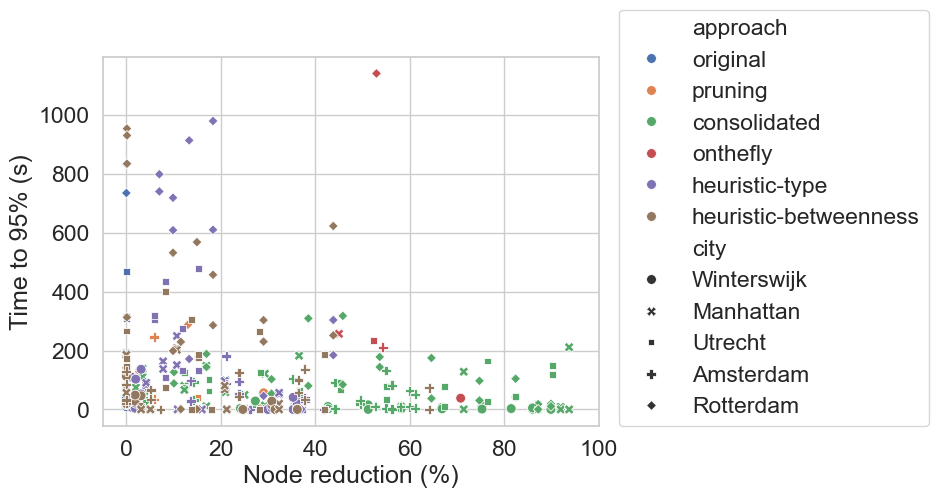

In [20]:
with sns.axes_style("whitegrid"):
    # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
    sns.scatterplot(data_all_best_across_seeds, x='node reduction (%)', y='time_to_best', hue='approach', style='city', s=50, legend="full")
    plt.legend(loc=(1.04, 0))
    plt.ylabel('Time to 95% (s)')
    plt.xlabel('Node reduction (%)')
    # plt.ylim(-5, 105)
    plt.xlim(-5, 100)
    
    # plt.savefig(f'figs/degradation_methods.png', bbox_inches='tight', dpi=300)

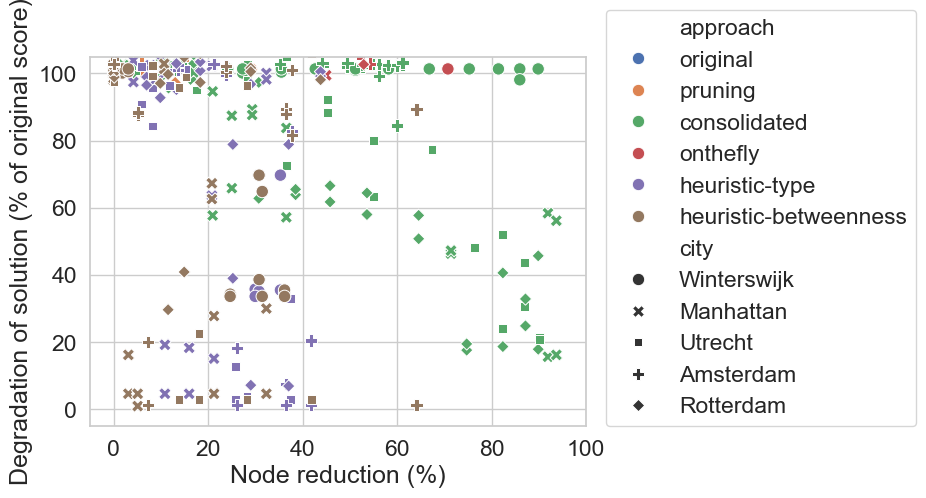

In [21]:
with sns.axes_style("whitegrid"):
    # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
    sns.scatterplot(data_all_best_across_seeds, x='node reduction (%)', y='% of original score', hue='approach', style='city', s=80, legend="full")
    plt.legend(loc=(1.04, 0))
    plt.ylabel('Degradation of solution (% of original score)')
    plt.xlabel('Node reduction (%)')
    plt.ylim(-5, 105)
    plt.xlim(-5, 100)
    
    plt.savefig(f'figs/degradation_methods.png', bbox_inches='tight', dpi=300)

[<matplotlib.lines.Line2D object at 0x000001780A1F0F90>, <matplotlib.lines.Line2D object at 0x0000017878CC14D0>, <matplotlib.lines.Line2D object at 0x0000017878CC1BD0>, <matplotlib.lines.Line2D object at 0x0000017878CC2210>, <matplotlib.lines.Line2D object at 0x0000017878CC27D0>]
[<matplotlib.lines.Line2D object at 0x000001780A1F0F90>, <matplotlib.lines.Line2D object at 0x0000017878CC14D0>, <matplotlib.lines.Line2D object at 0x0000017878CC2210>, <matplotlib.lines.Line2D object at 0x0000017878CC27D0>, <matplotlib.lines.Line2D object at 0x0000017878CC1BD0>]


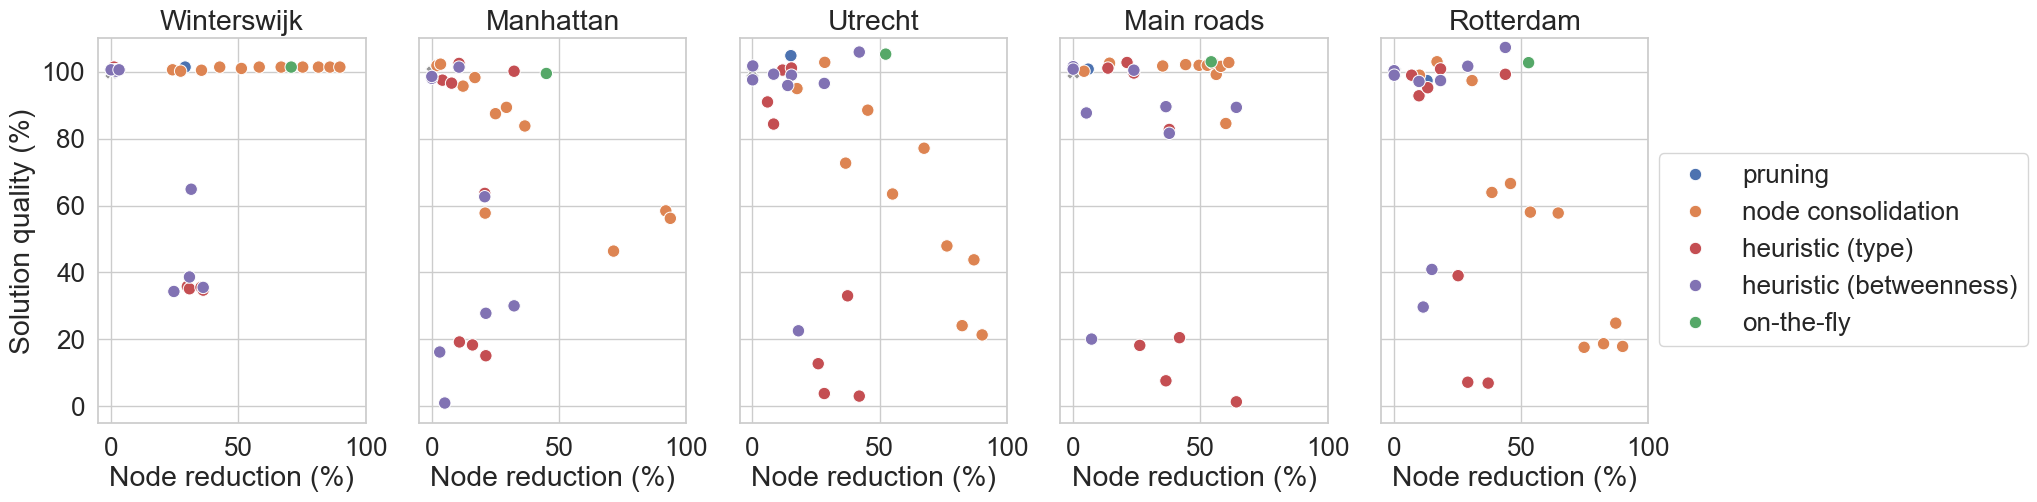

In [23]:
 sns.set(style={'style': "whitegrid", 'axes.grid' : False}, font_scale=1.7)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(20,5))

    for i, city in enumerate(data_all_best_across_seeds.city.unique()):
        data_filtered_orig = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "original" & city == "{city}"')
        sns.scatterplot(data_filtered_orig, x='node reduction (%)', y='% of original score', hue='approach', s=100, legend=False, ax=axes[i], palette='Greys', marker='X')
        
        data_filtered = data_all_best_across_seeds.query(f'SSR == "without_SSR" & city == "{city}" & approach != "original"')  # 
        # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
        if city != 'Rotterdam':
            sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='approach', s=80, legend=False, ax=axes[i])  #style='SSR', 
        else:
            sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='approach', s=80, legend='full', ax=axes[i])
        if city == 'Amsterdam': 
            axes[i].set_title('Main roads')
        else:
            axes[i].set_title(city)
        axes[i].set_ylabel('Solution quality (%)')
        axes[i].set_xlabel('Node reduction (%)')
            
    h, l = axes[i].get_legend_handles_labels()
    handles = [h[0], h[1], h[3], h[4], h[2]]  # to follow the same order as the paper
    labels = ['pruning', 'node consolidation', 'heuristic (type)', 'heuristic (betweenness)', 'on-the-fly']        
    axes[i].legend(handles=handles, labels=labels, loc=(1.04, 0.2))
    plt.ylim(-5, 110)
    plt.xlim(-5, 100)
        
    plt.savefig(f'figs/degradation_methods_cities.png', bbox_inches='tight', dpi=300)

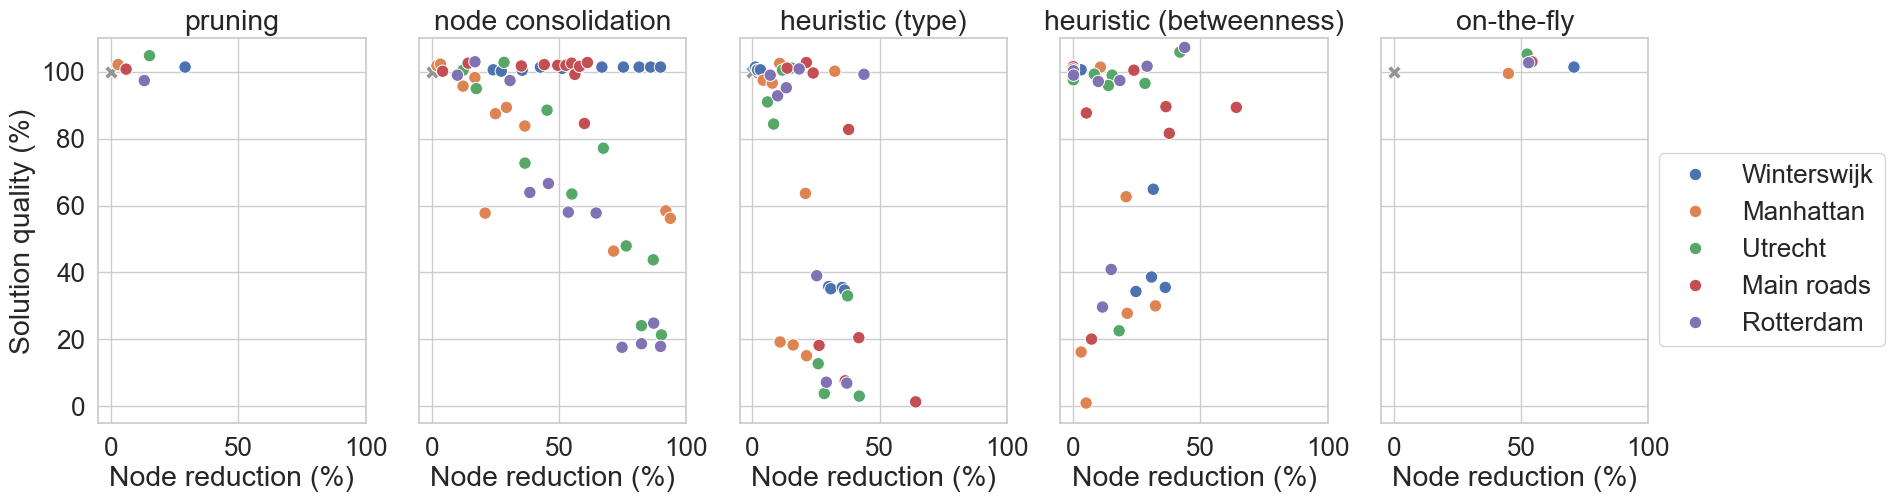

In [25]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(20,5))

    for j, approach in enumerate(['original', 'pruning', 'consolidated', 'heuristic-type', 'heuristic-betweenness', 'onthefly']):
        if approach != 'original':
            i = j-1
            data_filtered_orig = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "original" & city == "{city}"')
            sns.scatterplot(data_filtered_orig, x='node reduction (%)', y='% of original score', hue='approach', s=100, legend=False, ax=axes[i], palette='Greys', marker='X')
            
            data_filtered = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "{approach}"')
            # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
            if approach != 'onthefly':
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='city', s=80, legend=False, ax=axes[i])
            else:
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='city', s=80, legend='full', ax=axes[i])
            if approach == 'pruning':
                axes[i].set_title(approach)
            if approach == 'consolidated':
                axes[i].set_title('node consolidation')
            if approach == 'onthefly':
                axes[i].set_title('on-the-fly')
            if approach == 'heuristic-type':
                axes[i].set_title('heuristic (type)')
            if approach == 'heuristic-betweenness':
                axes[i].set_title('heuristic (betweenness)')
                
            axes[i].set_ylabel('Solution quality (%)')
            axes[i].set_xlabel('Node reduction (%)')
                 
    handles, l = axes[i].get_legend_handles_labels()
    labels = ['Winterswijk', 'Manhattan', 'Utrecht', 'Main roads', 'Rotterdam']        
    axes[i].legend(handles=handles, labels=labels, loc=(1.04, 0.2))
    plt.ylim(-5, 110)
    plt.xlim(-5, 100)
        
    plt.savefig(f'figs/degradation_methods_approaches.png', bbox_inches='tight', dpi=300)

In [23]:
data_all_best_across_seeds

,SSR,city,num nodes,node reduction (%),cross eval score,% of original score,seed,best_score,nfe_of_best,time_to_best,approach,earliest_nfe_of_95,num_nodes,tolerance,pruning,iterations,threshold
0,without_SSR,Winterswijk,1926.0,0.000000,0.736,100.000000,3,736.0,19626,41.536214,original,3443,NaN,NaN,NaN,NaN,NaN
1,without_SSR,Manhattan,2533.0,0.000000,0.758,100.000000,4,758.0,62329,189.848692,original,29717,NaN,NaN,NaN,NaN,NaN
2,without_SSR,Utrecht,4557.0,0.000000,0.551,100.000000,1,551.0,54283,307.572049,original,77076,NaN,NaN,NaN,NaN,NaN
3,without_SSR,Amsterdam,3241.0,0.000000,0.784,100.000000,8,784.0,5769,18.451011,original,91322,NaN,NaN,NaN,NaN,NaN
4,without_SSR,Rotterdam,7108.0,0.000000,0.331,100.000000,8,331.0,55763,734.535022,original,72047,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,with_SSR,Rotterdam,5804.0,18.345526,0.396,105.882353,1,387.0,28099,285.649976,heuristic-betweenness,28099,NaN,NaN,0.0,1000.0,1000.0
331,with_SSR,Rotterdam,6288.0,11.536297,0.373,99.732620,6,339.0,25252,229.457464,heuristic-betweenness,23054,NaN,NaN,1.0,1.0,0.0
332,with_SSR,Rotterdam,5044.0,29.037704,0.376,100.534759,4,333.0,33370,303.223331,heuristic-betweenness,37835,NaN,NaN,1.0,1.0,1000.0
333,with_SSR,Rotterdam,6046.0,14.940912,0.392,104.812834,6,374.0,62488,567.809995,heuristic-betweenness,25486,NaN,NaN,1.0,1000.0,0.0


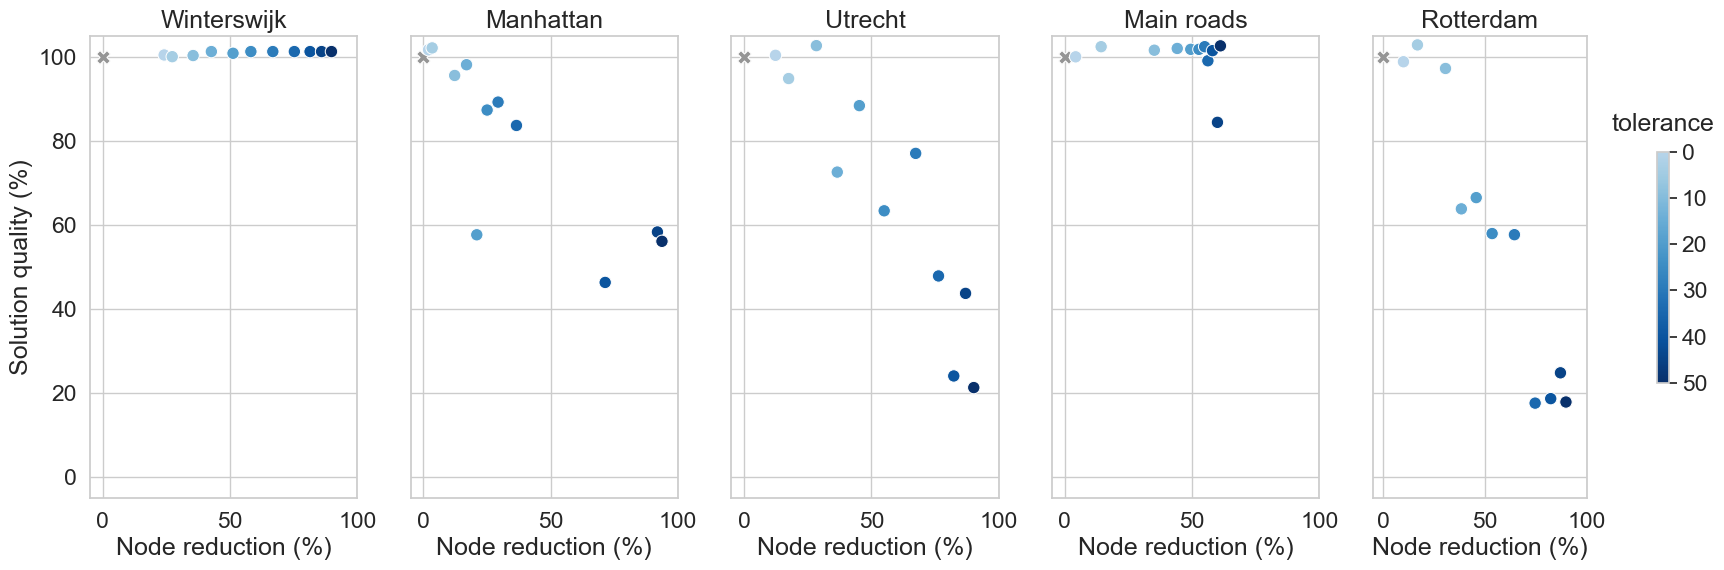

In [24]:
import cmasher as cmr
from matplotlib.cm import ScalarMappable
from matplotlib import colors
# for approach in ['original', 'pruning', 'consolidated', 'heuristic-type', 'heuristic-betweenness', 'onthefly']:
for approach in ['consolidated']:
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(20,6))
    
        for i, city in enumerate(data_all_best_across_seeds.city.unique()):
            data_filtered_orig = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "original" & city == "{city}"')
            sns.scatterplot(data_filtered_orig, x='node reduction (%)', y='% of original score', hue='approach', s=100, legend=False, ax=axes[i], palette='Greys', marker='X')
            
            data_filtered = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "{approach}" & city == "{city}"')
            
            cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
            
            # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
            if city != 'Rotterdam':
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='tolerance', palette=cmap, s=80, legend=False, ax=axes[i])
            else:
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='tolerance', palette=cmap, s=80, legend=False, ax=axes[i])
            if city == 'Amsterdam': 
                axes[i].set_title('Main roads')
            else:
                axes[i].set_title(city)
            axes[i].set_ylabel('Solution quality (%)')
            axes[i].set_xlabel('Node reduction (%)')
            # axes[i].figure(layout='constrained')
                
        # axes[i].legend(loc=(1.04, 0.2))
        # plt.title(approach)
        plt.ylim(-5, 105)
        plt.xlim(-5, 100)
        # plt.ylabel('Degradation of solution (% of original score)')
        # plt.figure(layout='constrained')
        
        sm =  ScalarMappable(norm=colors.Normalize(vmin=0, vmax=50), cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes[i], shrink=0.5, anchor=(2, 0.5))
        cbar.ax.set_title("tolerance", pad=15)
        cbar.ax.invert_yaxis()
            
        plt.savefig(f'figs/degradation_methods_cities_{approach}.png', bbox_inches='tight', dpi=300)

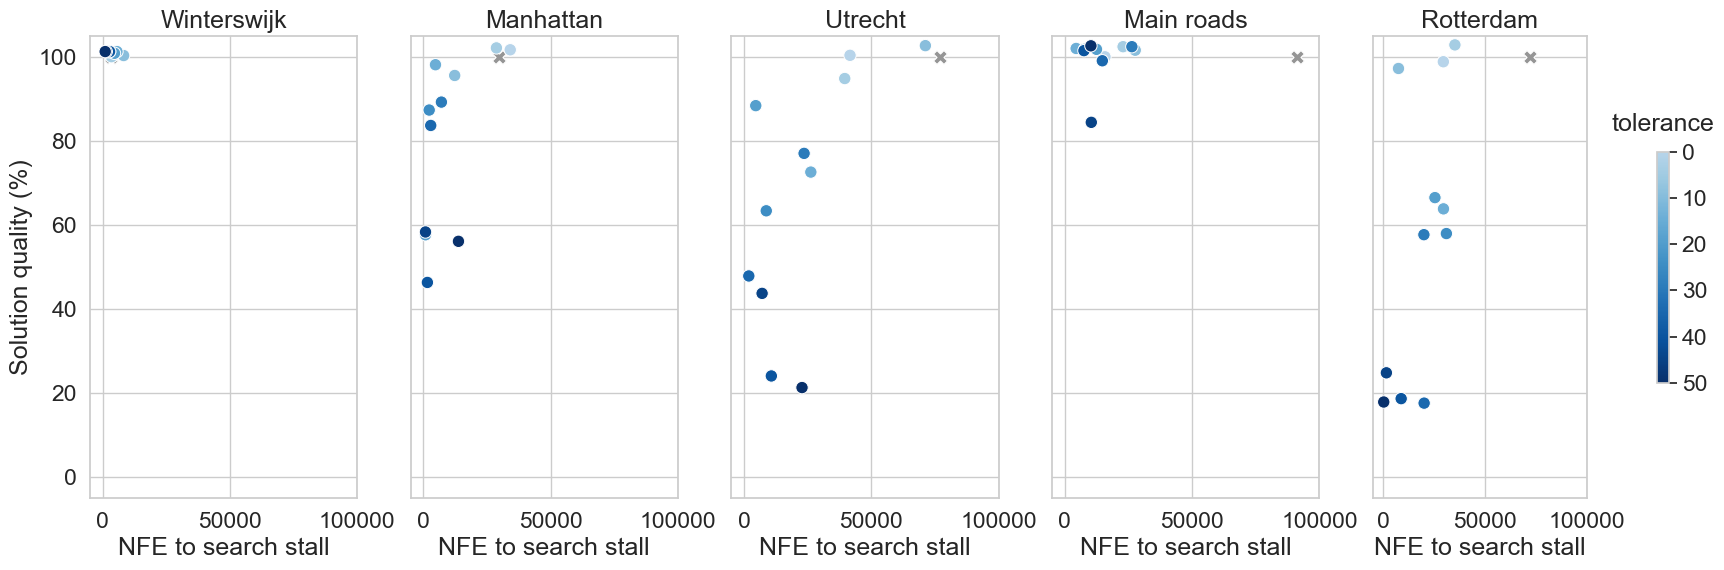

In [25]:
# for approach in ['original', 'pruning', 'consolidated', 'heuristic-type', 'heuristic-betweenness', 'onthefly']:
for approach in ['consolidated']:
# for approach in ['heuristic-type', 'heuristic-betweenness']:
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(20,6))
    
        for i, city in enumerate(data_all_best_across_seeds.city.unique()):
            data_filtered_orig = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "original" & city == "{city}"')  # 
            sns.scatterplot(data_filtered_orig, x='earliest_nfe_of_95', y='% of original score', hue='SSR', s=100, legend=False, ax=axes[i], palette='Greys', marker='X')
            data_filtered = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "{approach}" & city == "{city}"')  # SSR == "without_SSR" & 
            
            cmap = cmr.get_sub_cmap('Blues', 0.3, 1)

            if city != 'Rotterdam':
                sns.scatterplot(data_filtered, x='earliest_nfe_of_95', y='% of original score', hue='tolerance', palette=cmap, s=80, legend=False, ax=axes[i])
            else:
                sns.scatterplot(data_filtered, x='earliest_nfe_of_95', y='% of original score', hue='tolerance', palette=cmap, s=80, legend=False, ax=axes[i])

            if city == 'Amsterdam':
                axes[i].set_title('Main roads')
            else:
                axes[i].set_title(city)
            axes[i].set_ylabel('Solution quality (%)')
            axes[i].set_xlabel('NFE to search stall')
            # axes[i].figure(layout='constrained')
                
        # axes[i].legend(loc=(1.04, 0.2))
        sm =  ScalarMappable(norm=colors.Normalize(vmin=0, vmax=50), cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes[i], shrink=0.5, anchor=(2, 0.5))
        cbar.ax.set_title("tolerance", pad=15)
        cbar.ax.invert_yaxis()
        
        # plt.title(approach)
        # fig.suptitle(approach)
        plt.ylim(-5, 105)
        plt.xlim(-5000, 100000)
        # plt.ylabel('Degradation of solution (% of original score)')
        # plt.figure(layout='constrained')
            
        plt.savefig(f'figs/nfe_cities_{approach}_orig_withoutSSR.png', bbox_inches='tight', dpi=300)  # 
        plt.show()
        # plt.close(fig)

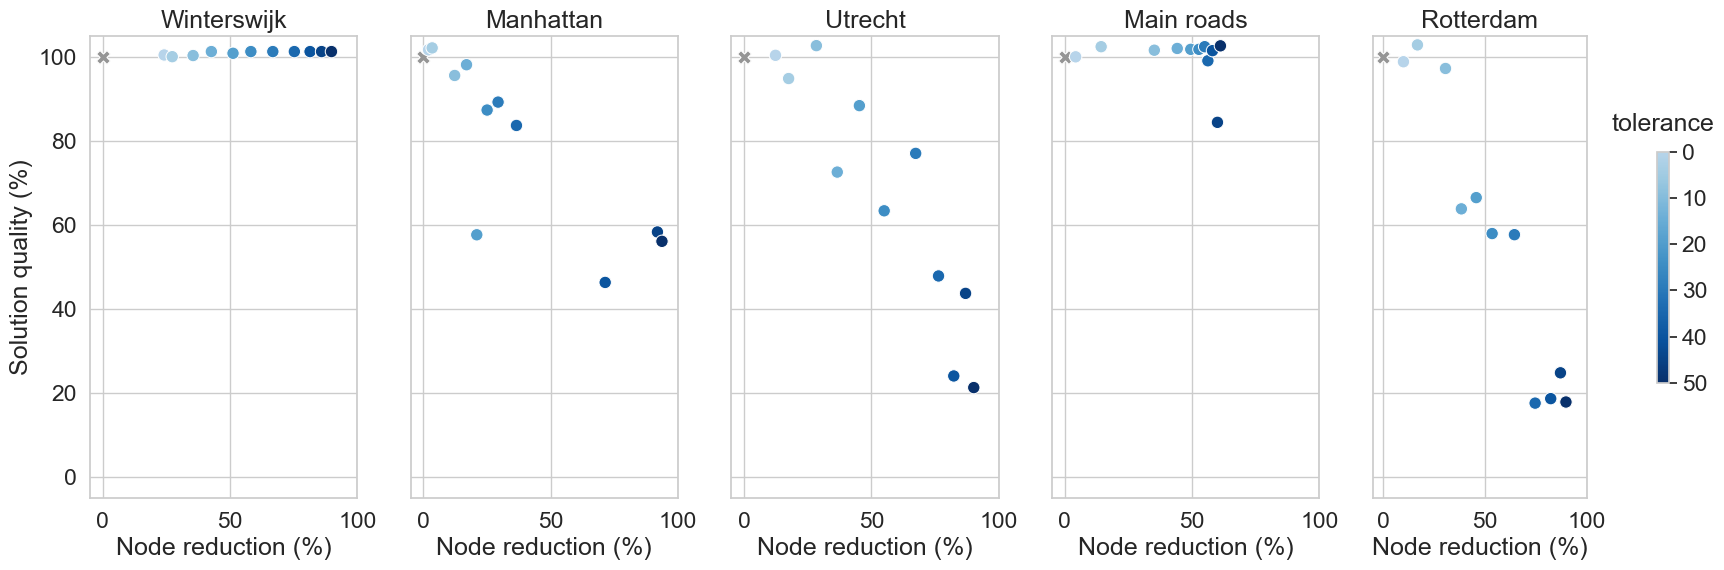

In [26]:
import cmasher as cmr
from matplotlib.cm import ScalarMappable
from matplotlib import colors
# for approach in ['original', 'pruning', 'consolidated', 'heuristic-type', 'heuristic-betweenness', 'onthefly']:
for approach in ['consolidated']:
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(20,6))
    
        for i, city in enumerate(data_all_best_across_seeds.city.unique()):
            data_filtered_orig = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "original" & city == "{city}"')
            sns.scatterplot(data_filtered_orig, x='node reduction (%)', y='% of original score', hue='approach', s=100, legend=False, ax=axes[i], palette='Greys', marker='X')
            
            data_filtered = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "{approach}" & city == "{city}"')
            
            cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
            
            # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
            if city != 'Rotterdam':
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='tolerance', palette=cmap, s=80, legend=False, ax=axes[i])
            else:
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='tolerance', palette=cmap, s=80, legend=False, ax=axes[i])
            if city == 'Amsterdam': 
                axes[i].set_title('Main roads')
            else:
                axes[i].set_title(city)
            axes[i].set_ylabel('Solution quality (%)')
            axes[i].set_xlabel('Node reduction (%)')
            # axes[i].figure(layout='constrained')
                
        # axes[i].legend(loc=(1.04, 0.2))
        # plt.title(approach)
        plt.ylim(-5, 105)
        plt.xlim(-5, 100)
        # plt.ylabel('Degradation of solution (% of original score)')
        # plt.figure(layout='constrained')
        
        sm =  ScalarMappable(norm=colors.Normalize(vmin=0, vmax=50), cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes[i], shrink=0.5, anchor=(2, 0.5))
        cbar.ax.set_title("tolerance", pad=15)
        cbar.ax.invert_yaxis()
            
        plt.savefig(f'figs/degradation_methods_cities_{approach}.png', bbox_inches='tight', dpi=300)

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\399484017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['pruning'] = [x==1 for x in data_filtered['pruning']]
C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\399484017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['iterations'] = [int(x) for x in data_filtered['iterations']]
C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\399484017.py:12: SettingWithCopyWarning: 
A value is trying to be se

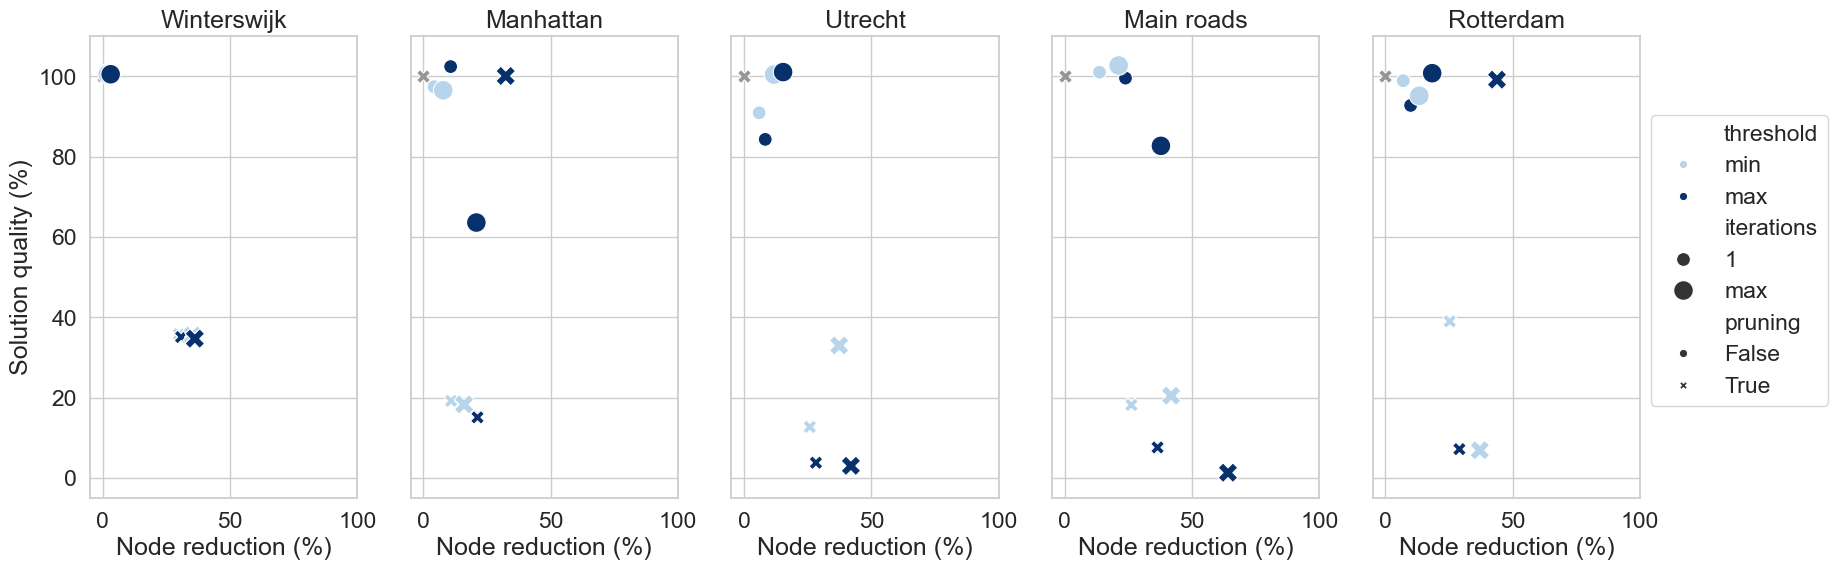

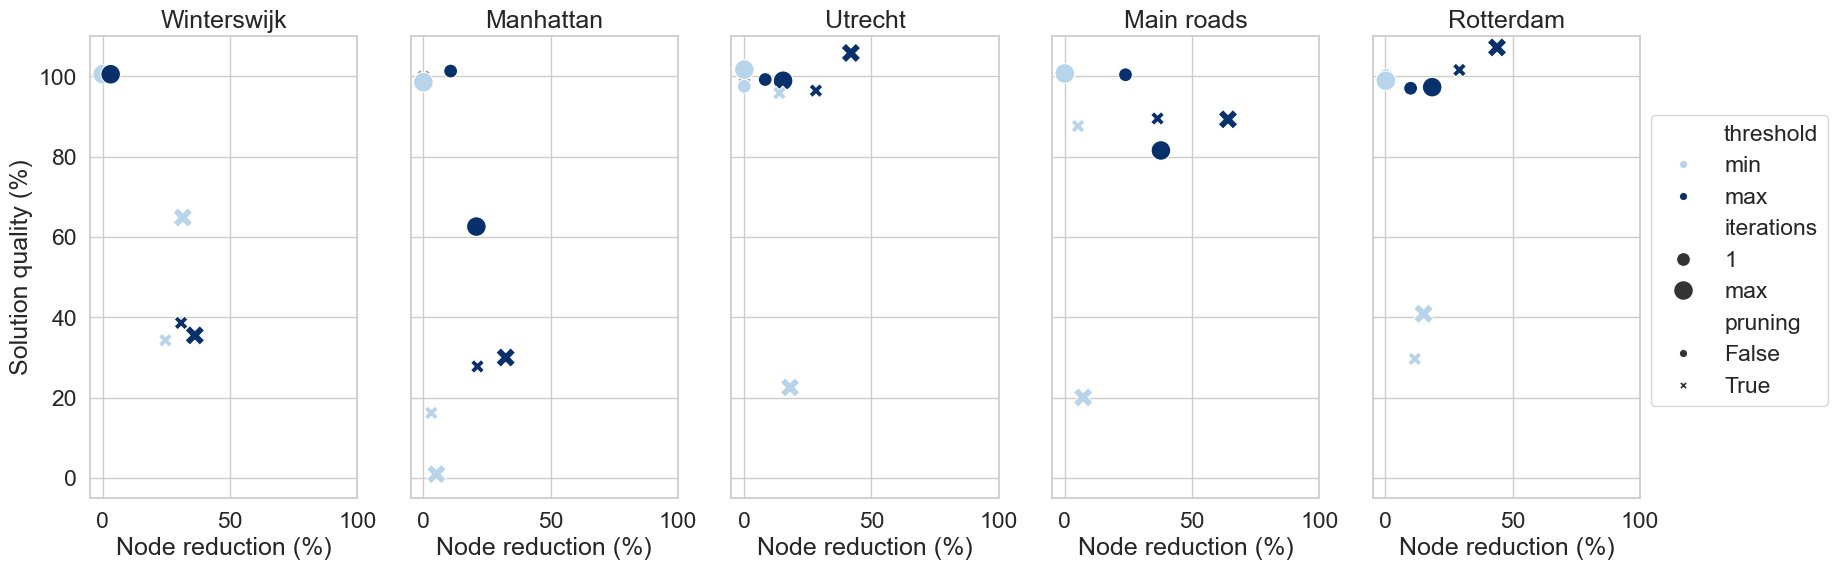

In [27]:
for approach in ['heuristic-type', 'heuristic-betweenness']:
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(20,6))
    
        for i, city in enumerate(data_all_best_across_seeds.city.unique()):
            data_filtered_orig = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "original" & city == "{city}"')
            sns.scatterplot(data_filtered_orig, x='node reduction (%)', y='% of original score', hue='approach', s=100, legend=False, ax=axes[i], palette='Greys', marker='X')
            
            data_filtered = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "{approach}" & city == "{city}"')
            data_filtered['pruning'] = [x==1 for x in data_filtered['pruning']]
            data_filtered['iterations'] = [int(x) for x in data_filtered['iterations']]
            data_filtered['threshold'] = [int(x) for x in data_filtered['threshold']]
            
            cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
            
            # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
            if city != 'Rotterdam':
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='threshold', style='pruning', size='iterations', sizes=(100, 200), palette=cmap, legend=False, ax=axes[i])
            else:
                sns.scatterplot(data_filtered, x='node reduction (%)', y='% of original score', hue='threshold', style='pruning', size='iterations', sizes=(100, 200), palette=cmap, legend=True, ax=axes[i])
            if city == 'Amsterdam': 
                axes[i].set_title('Main roads')
            else:
                axes[i].set_title(city)
            axes[i].set_ylabel('Solution quality (%)')
            axes[i].set_xlabel('Node reduction (%)')
            # axes[i].figure(layout='constrained')
                
        handles, l = axes[i].get_legend_handles_labels()
        labels = ['threshold', 'min', 'max', 'iterations', '1', 'max', 'pruning', 'False', 'True']
        axes[i].legend(handles=handles, labels=labels, loc=(1.04, 0.2))
        
        plt.ylim(-5, 110)
        plt.xlim(-5, 100)
        # plt.ylabel('Degradation of solution (% of original score)')
        # plt.figure(layout='constrained')
        
        # sm =  ScalarMappable(norm=colors.Normalize(vmin=0, vmax=50), cmap=cmap)
        # sm.set_array([])
        # cbar = fig.colorbar(sm, ax=axes[i], shrink=0.5, anchor=(2, 0.5))
        # cbar.ax.set_title("tolerance", pad=15)
        # cbar.ax.invert_yaxis()
            
        plt.savefig(f'figs/degradation_methods_cities_{approach}.png', bbox_inches='tight', dpi=300)

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\4244402135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['pruning'] = [x==1 for x in data_filtered['pruning']]
C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\4244402135.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['iterations'] = [int(x) for x in data_filtered['iterations']]
C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\4244402135.py:12: SettingWithCopyWarning: 
A value is trying to be

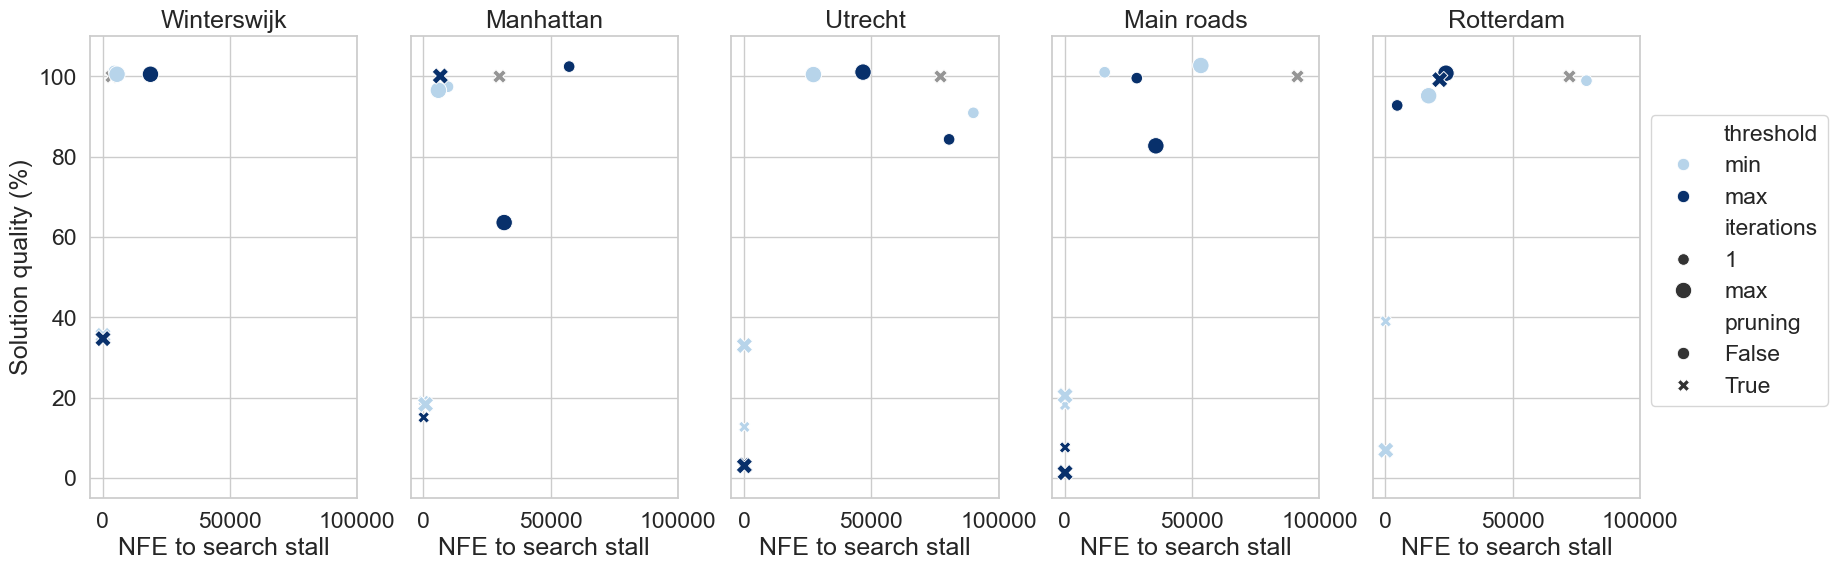

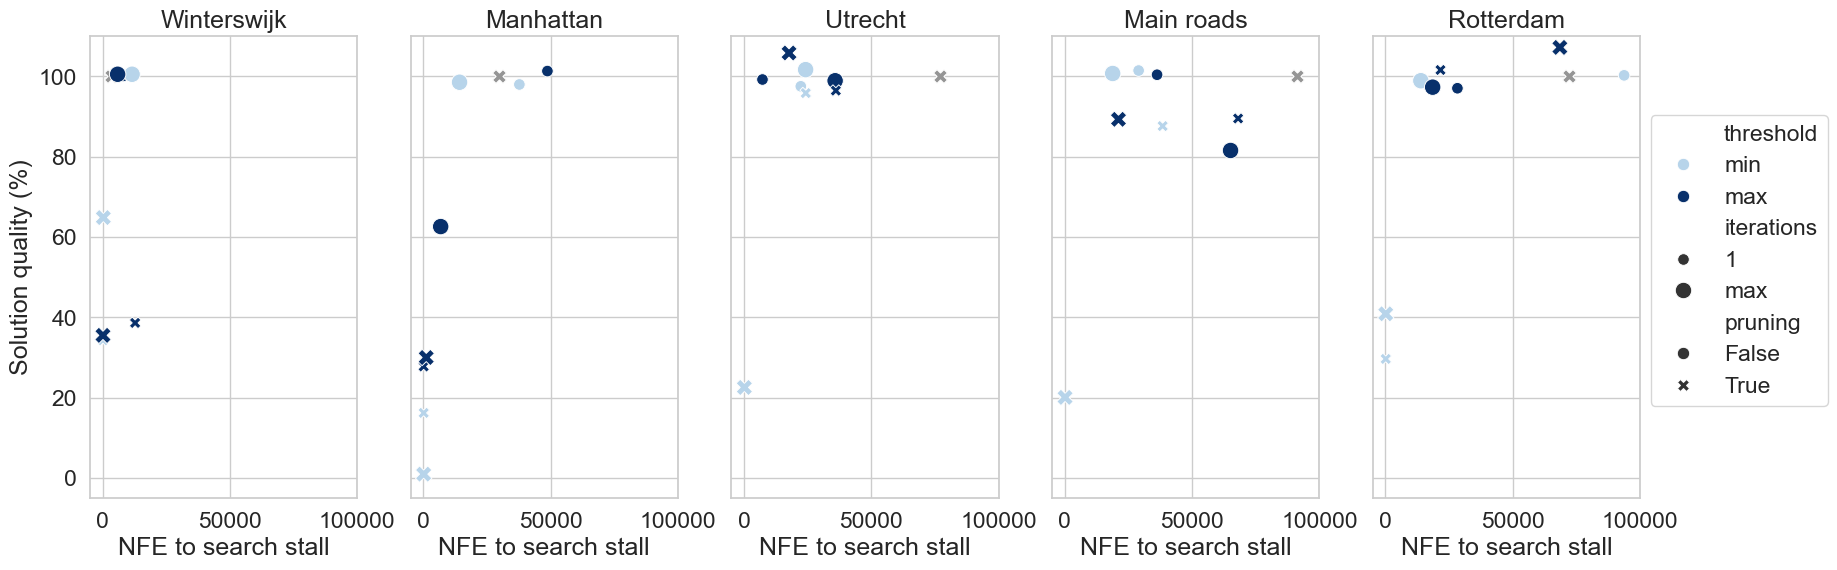

In [28]:
for approach in ['heuristic-type', 'heuristic-betweenness']:
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 5,sharex=True,sharey=True, figsize=(20,6))
    
        for i, city in enumerate(data_all_best_across_seeds.city.unique()):
            data_filtered_orig = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "original" & city == "{city}"')
            sns.scatterplot(data_filtered_orig, x='earliest_nfe_of_95', y='% of original score', hue='approach', s=100, legend=False, ax=axes[i], palette='Greys', marker='X')
            
            data_filtered = data_all_best_across_seeds.query(f'SSR == "without_SSR" & approach == "{approach}" & city == "{city}"')
            data_filtered['pruning'] = [x==1 for x in data_filtered['pruning']]
            data_filtered['iterations'] = [int(x) for x in data_filtered['iterations']]
            data_filtered['threshold'] = [int(x) for x in data_filtered['threshold']]
            
            cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
            
            # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
            if city != 'Rotterdam':
                sns.scatterplot(data_filtered, x='earliest_nfe_of_95', y='% of original score', hue='threshold', style='pruning', size='iterations', sizes=(70, 140), palette=cmap, s=80, legend=False, ax=axes[i])
            else:
                sns.scatterplot(data_filtered, x='earliest_nfe_of_95', y='% of original score', hue='threshold', style='pruning', size='iterations', sizes=(70, 140), palette=cmap, s=80, legend=True, ax=axes[i])
            if city == 'Amsterdam': 
                axes[i].set_title('Main roads')
            else:
                axes[i].set_title(city)
            axes[i].set_ylabel('Solution quality (%)')
            axes[i].set_xlabel('NFE to search stall')
            # axes[i].figure(layout='constrained')
                
        handles, l = axes[i].get_legend_handles_labels()
        labels = ['threshold', 'min', 'max', 'iterations', '1', 'max', 'pruning', 'False', 'True']
        axes[i].legend(handles=handles, labels=labels, loc=(1.04, 0.2))
        
        plt.ylim(-5, 110)
        plt.xlim(-5000, 100000)
        # plt.ylabel('Degradation of solution (% of original score)')
        # plt.figure(layout='constrained')
            
        plt.savefig(f'figs/nfe_cities_{approach}_orig_withoutSSR.png', bbox_inches='tight', dpi=300)  # 

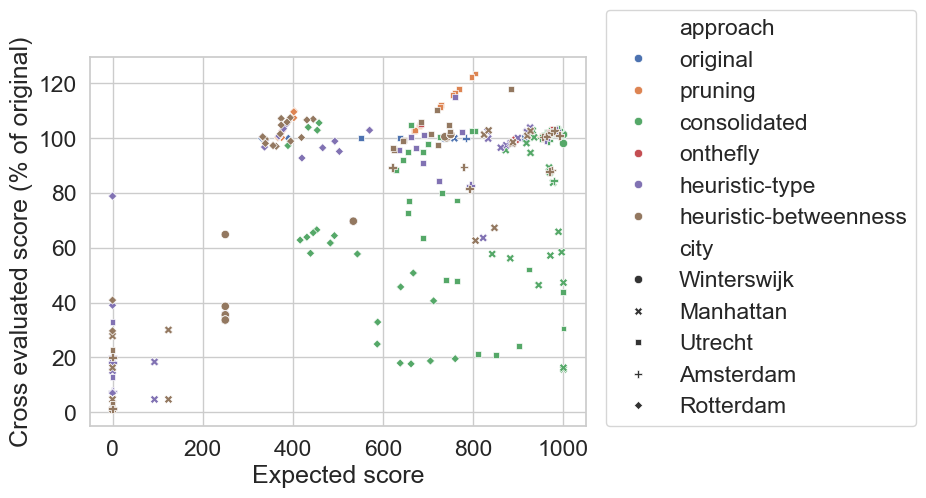

In [29]:
with sns.axes_style("whitegrid"):
    # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
    sns.scatterplot(data_all_best_across_seeds, x='best_score', y='% of original score', hue='approach', style='city', legend="full")
    plt.legend(loc=(1.04, 0))
    plt.xlabel('Expected score')
    plt.ylabel("Cross evaluated score (% of original)")
    # plt.ylim(0, 100000)
    # plt.xlim(-5, 50)
    
    # plt.savefig(f'figs/expected_vs_real.png', bbox_inches='tight', dpi=300)

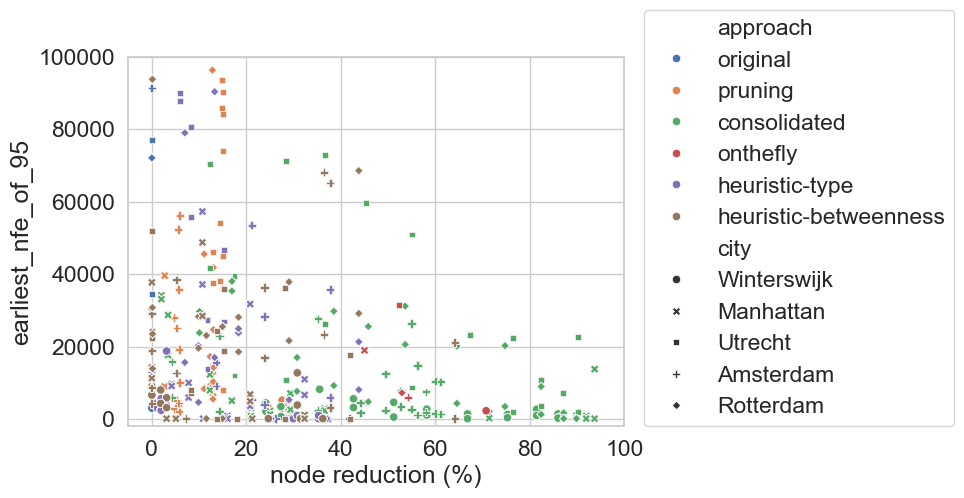

In [30]:
with sns.axes_style("whitegrid"):
    # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
    sns.scatterplot(data_all_best, x='node reduction (%)', y='earliest_nfe_of_95',  hue='approach', style='city', legend="full")
    plt.legend(loc=(1.04, 0))
    # plt.xlabel('Expected score')
    # plt.ylabel("Cross evaluated score")
    plt.ylim(-2000, 100000)
    # plt.xlim(-5, 50)
    plt.xlim(-5, 100)
    
    # plt.savefig(f'figs/node red nfe of best.png', bbox_inches='tight', dpi=300)

In [31]:
data_all_best.columns

Index(['SSR', 'city', 'num nodes', 'node reduction (%)', 'cross eval score',
       '% of original score', 'seed', 'best_score', 'nfe_of_best',
       'time_to_best', 'approach', 'earliest_nfe_of_95', 'num_nodes',
       'tolerance', 'pruning', 'iterations', 'threshold'],
      dtype='object')

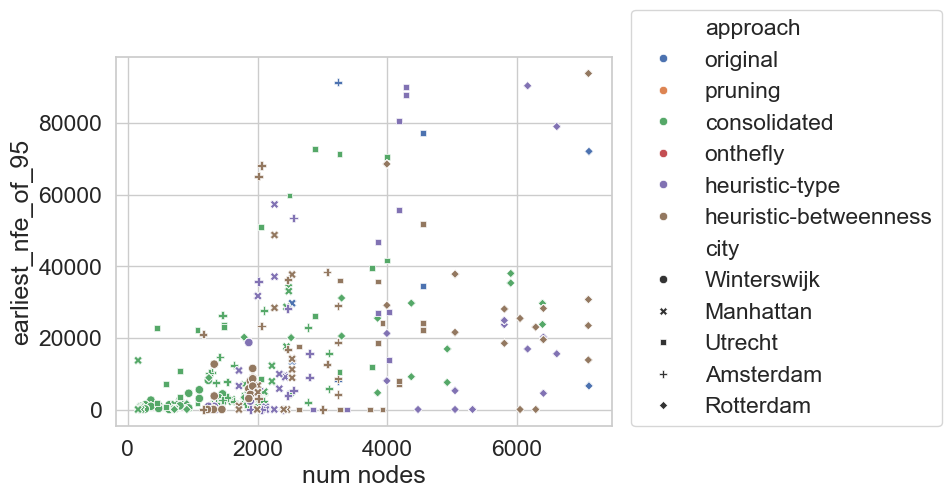

In [32]:
with sns.axes_style("whitegrid"):
    # sns.scatterplot(data, x='% node reduction', y='% degradation', hue='weights', style='city', size='pruning', legend="full")
    sns.scatterplot(data_all_best, x='num nodes', y='earliest_nfe_of_95',  hue='approach', style='city', legend="full")
    plt.legend(loc=(1.04, 0))
    # plt.xlabel('Expected score')
    # plt.ylabel("Cross evaluated score")
    # plt.ylim(0, 100000)
    # plt.xlim(-5, 50)
    
    # plt.savefig(f'figs/num nodes nfe of best.png', bbox_inches='tight', dpi=300)

In [33]:
results_best_orig

,SSR,city,num nodes,node reduction (%),cross eval score,% of original score,seed,best_score,nfe_of_best,time_to_best,approach,earliest_nfe_of_95
0,without_SSR,Winterswijk,1926,0.0,0.737,100,0,737.0,6615,13.999901,original,3443
0,without_SSR,Winterswijk,1926,0.0,0.740,100,1,740.0,57472,121.633001,original,3443
0,without_SSR,Winterswijk,1926,0.0,0.737,100,2,737.0,21241,44.954179,original,3443
0,without_SSR,Winterswijk,1926,0.0,0.736,100,3,736.0,19626,41.536214,original,3443
0,without_SSR,Winterswijk,1926,0.0,0.736,100,4,736.0,35296,74.700000,original,3443
...,...,...,...,...,...,...,...,...,...,...,...,...
0,with_SSR,Rotterdam,7108,0.0,0.386,100,5,386.0,38886,512.223676,original,6662
0,with_SSR,Rotterdam,7108,0.0,0.359,100,6,359.0,22991,302.847671,original,6662
0,with_SSR,Rotterdam,7108,0.0,0.362,100,7,362.0,31744,418.146078,original,6662
0,with_SSR,Rotterdam,7108,0.0,0.390,100,8,390.0,63254,833.209803,original,6662


In [45]:
results_best_orig['Percentage of routes intercepted'] = results_best_orig['best_score']/10
results_best_pruning['Percentage of routes intercepted'] = results_best_pruning['best_score']/10

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\788066858.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x, y, xerr=std_nfe, yerr=std_score, mfc=color, mec=color, ecolor=color, fmt='o', marker=markers[city], markersize=10)


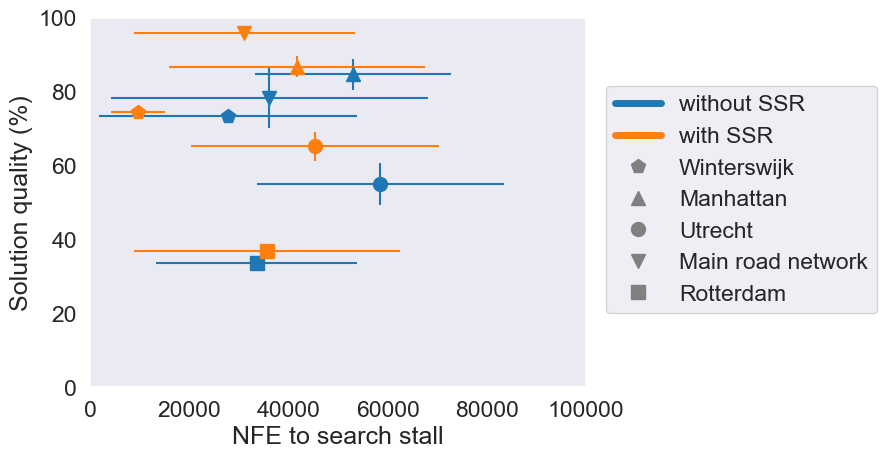

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

for SSR in ['without_SSR', 'with_SSR']:
    for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
        if SSR == 'with_SSR':
            color = 'tab:orange'
        else:
            color = 'tab:blue'
        x = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['nfe_of_best'].mean(axis=0)
        y = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['Percentage of routes intercepted'].mean(axis=0)
        std_nfe = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['nfe_of_best'].std(axis=0)
        std_score = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['Percentage of routes intercepted'].std(axis=0)
        
        markers={
            'Winterswijk': 'p',
            'Manhattan': '^',
            'Utrecht': 'o', 
            'Amsterdam': 'v',
            'Rotterdam': 's'
        }
             
        plt.errorbar(x, y, xerr=std_nfe, yerr=std_score, mfc=color, mec=color, ecolor=color, fmt='o', marker=markers[city], markersize=10)
        
        plt.ylim(0, 100)
        plt.xlim(-5, 100000)

marker_withoutSSR = mlines.Line2D([], [], color='tab:blue', linewidth=5,
                          label='without SSR')
marker_withSSR = mlines.Line2D([], [], color='tab:orange', linewidth=5,
                          label='with SSR')
marker_ww = mlines.Line2D([], [], color='grey', marker='p', linestyle='None',
                          markersize=10, label='Winterswijk')
marker_mh = mlines.Line2D([], [], color='grey', marker='^', linestyle='None',
                          markersize=10, label='Manhattan')
marker_utr = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                          markersize=10, label='Utrecht')
marker_ams = mlines.Line2D([], [], color='grey', marker='v', linestyle='None',
                          markersize=10, label='Main road network')
marker_rot = mlines.Line2D([], [], color='grey', marker='s', linestyle='None',
                          markersize=10, label='Rotterdam')

plt.legend(handles=[marker_withoutSSR, marker_withSSR, marker_ww, marker_mh, marker_utr, marker_ams, marker_rot], loc=(1.04, 0.2))

plt.xlabel('NFE to search stall')    
plt.ylabel('Solution quality (%)')   
plt.savefig(f'figs/impact of SSR on orig.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\3810858115.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x, y, xerr=std_nfe, yerr=std_score, mfc=color, mec=color, ecolor=color, fmt='o', marker=markers[city], markersize=10)


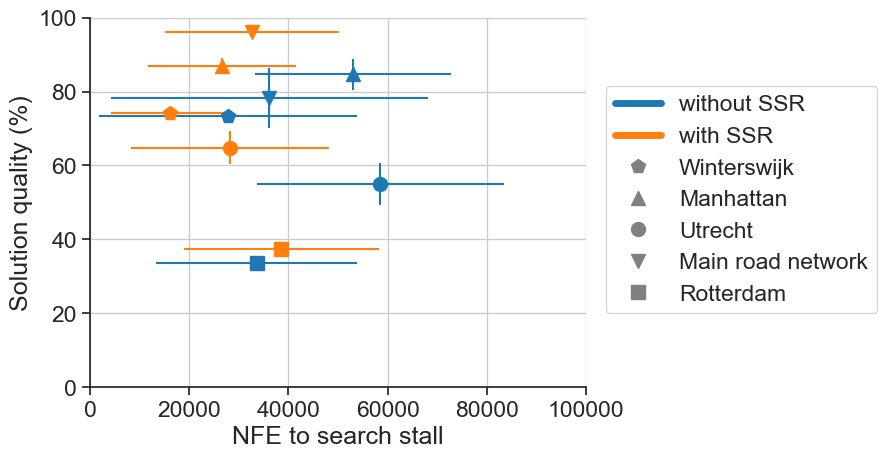

In [47]:
import numpy as np
import matplotlib.pyplot as plt
with sns.axes_style("ticks"):
    for SSR in ['without_SSR', 'with_SSR']:
        for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
            if SSR == 'with_SSR':
                color = 'tab:orange'
            else:
                color = 'tab:blue'
            if SSR == 'without_SSR':
                x = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['nfe_of_best'].mean(axis=0)
                y = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['Percentage of routes intercepted'].mean(axis=0)
                std_nfe = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['nfe_of_best'].std(axis=0)
                std_score = results_best_orig.query(f'SSR == "{SSR}" & city == "{city}"')['Percentage of routes intercepted'].std(axis=0)
            else: 
                x = results_best_pruning.query(f'SSR == "{SSR}" & city == "{city}"')['nfe_of_best'].mean(axis=0)
                y = results_best_pruning.query(f'SSR == "{SSR}" & city == "{city}"')['Percentage of routes intercepted'].mean(axis=0)
                std_nfe = results_best_pruning.query(f'SSR == "{SSR}" & city == "{city}"')['nfe_of_best'].std(axis=0)
                std_score = results_best_pruning.query(f'SSR == "{SSR}" & city == "{city}"')['Percentage of routes intercepted'].std(axis=0)
                
            markers={
                'Winterswijk': 'p',
                'Manhattan': '^',
                'Utrecht': 'o', 
                'Amsterdam': 'v',
                'Rotterdam': 's'
            }
                 
            plt.errorbar(x, y, xerr=std_nfe, yerr=std_score, mfc=color, mec=color, ecolor=color, fmt='o', marker=markers[city], markersize=10)
    
            plt.ylim(0, 100)
            plt.xlim(-5, 100000)
    
    marker_withoutSSR = mlines.Line2D([], [], color='tab:blue', linewidth=5,
                              label='without SSR')
    marker_withSSR = mlines.Line2D([], [], color='tab:orange', linewidth=5,
                              label='with SSR')
    marker_ww = mlines.Line2D([], [], color='grey', marker='p', linestyle='None',
                              markersize=10, label='Winterswijk')
    marker_mh = mlines.Line2D([], [], color='grey', marker='^', linestyle='None',
                              markersize=10, label='Manhattan')
    marker_utr = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                              markersize=10, label='Utrecht')
    marker_ams = mlines.Line2D([], [], color='grey', marker='v', linestyle='None',
                              markersize=10, label='Main road network')
    marker_rot = mlines.Line2D([], [], color='grey', marker='s', linestyle='None',
                              markersize=10, label='Rotterdam')
    
    plt.legend(handles=[marker_withoutSSR, marker_withSSR, marker_ww, marker_mh, marker_utr, marker_ams, marker_rot], loc=(1.04, 0.2))
    
    sns.despine()
    plt.grid(True)
    
    plt.xlabel('NFE to search stall')    
    plt.ylabel('Solution quality (%)')   
    plt.savefig(f'figs/impact of SSR on pruned.png', bbox_inches='tight', dpi=300)
    plt.show()

# Pruning and onthefly paper plots

In [16]:
# make dataframe with orig & pruning/otf data
with open(f'./cleaned_data/num_nodes_pruning.pkl', 'rb') as f:
    num_nodes = pickle.load(f)
    
max_iter_dict = {
    'Winterswijk': 5,
    'Manhattan': 1,
    'Utrecht': 6, 
    'Amsterdam': 6, 
    'Rotterdam': 7
}

results_seedplot = pd.DataFrame()
for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
    results_seedplot_city = pd.DataFrame()
    results_seedplot_city['Solution quality (%)'] = (
        results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']/
        max(results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']))*100 # nfe_of_best
    results_seedplot_city['NFE to search stall'] = results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['nfe_of_best']
    results_seedplot_city['city'] = city
    results_seedplot_city['algo'] = 'uncoarsened'
    results_seedplot = pd.concat([results_seedplot, results_seedplot_city])
    
    results_seedplot_city = pd.DataFrame()
    results_seedplot_city['Solution quality (%)'] = (
        results_best_pruning.query(f'SSR == "without_SSR" & num_nodes == {num_nodes[city, max_iter_dict[city]-1]} & city == "{city}"')['cross eval score']/
        max(results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']))*100 # nfe_of_best
    results_seedplot_city['NFE to search stall'] = results_best_pruning.query(f'SSR == "without_SSR" & num_nodes == {num_nodes[city, max_iter_dict[city]-1]} & city == "{city}"')['nfe_of_best']
    results_seedplot_city['city'] = city
    results_seedplot_city['algo'] = 'pruning'
    results_seedplot = pd.concat([results_seedplot, results_seedplot_city])
    
results_seedplot
# plots (from paper3) (solqual + nfe)

,Solution quality (%),NFE to search stall,city,algo
0,99.594595,6615,Winterswijk,uncoarsened
0,100.000000,57472,Winterswijk,uncoarsened
0,99.594595,21241,Winterswijk,uncoarsened
0,99.459459,19626,Winterswijk,uncoarsened
0,99.459459,35296,Winterswijk,uncoarsened
...,...,...,...,...
0,95.989305,50725,Rotterdam,pruning
0,91.978610,71289,Rotterdam,pruning
0,93.582888,16680,Rotterdam,pruning
0,90.909091,35586,Rotterdam,pruning


C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_19624\4158981393.py:2: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.catplot(results_seedplot, y='Solution quality (%)', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)


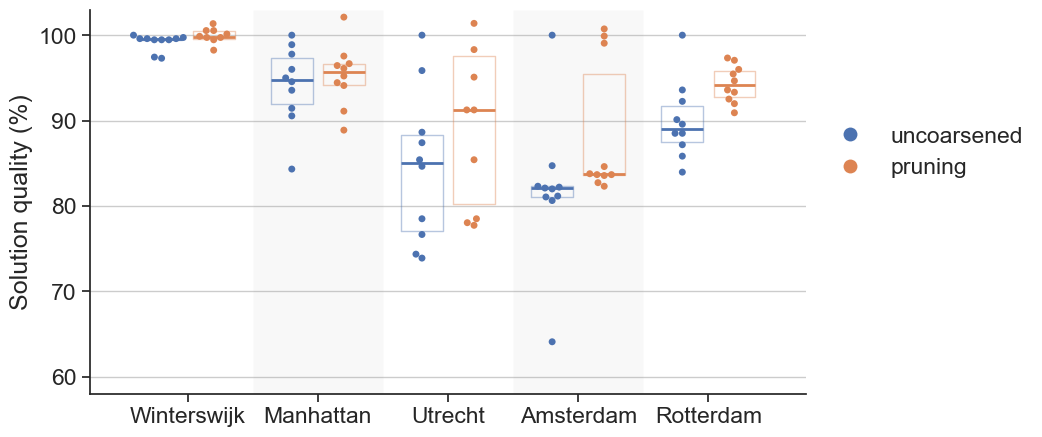

In [19]:
sns.set_style("ticks")
sns.catplot(results_seedplot, y='Solution quality (%)', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)

ax = sns.swarmplot(data=results_seedplot, y='Solution quality (%)', x = 'city', hue='algo', dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), markerscale=2, frameon=False)  

# g.map(sns.catplot(results, y='best_score', x = '|U|, |S|', hue='approach', palette=my_palette, kind='swarm', dodge=True, ))
# ww: 2.6, mh: 1.8
plt.ylim(58, 103)
ax.set(xlabel='')
for x in range(0, len(results_seedplot['city'].unique())):
    plt.axvspan(x - 0.5, x + 0.5, facecolor='gray', alpha=[0 if x%2 == 0 else 0.05][0])
ax.grid(axis='y')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:], labels=labels[:])
ax.legend_.set_title(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), frameon=False)   # , markerscale=2

plt.savefig(f'figs/pruning_score_swarmplot.png', dpi=300, bbox_inches='tight')

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_19624\3983182591.py:2: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.catplot(results_seedplot, y='NFE to search stall', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)


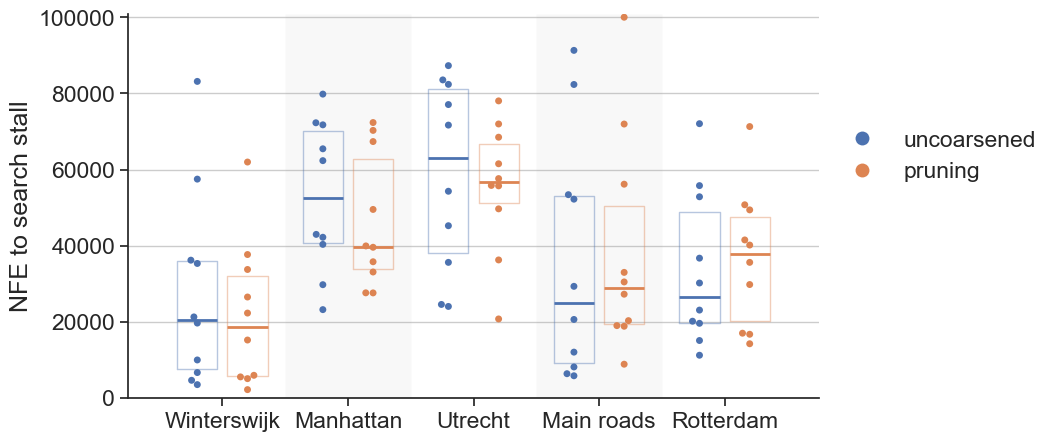

In [20]:
sns.set_style("ticks")
sns.catplot(results_seedplot, y='NFE to search stall', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)

ax = sns.swarmplot(data=results_seedplot, y='NFE to search stall', x = 'city', hue='algo', dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), markerscale=2, frameon=False)  

plt.ylim(0, 101000)
ax.set(xlabel='')
for x in range(0, len(results_seedplot['city'].unique())):
    plt.axvspan(x - 0.5, x + 0.5, facecolor='gray', alpha=[0 if x%2 == 0 else 0.05][0])
ax.grid(axis='y')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:], labels=labels[:])
ax.legend_.set_title(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), frameon=False)   # , markerscale=2

plt.xticks(range(5), ['Winterswijk', 'Manhattan', 'Utrecht', 'Main roads', 'Rotterdam'])

plt.savefig(f'figs/pruning_nfe_swarmplot.png', dpi=300, bbox_inches='tight')

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_27276\46195509.py:26: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.catplot(results_seedplot, y='Solution quality (%)', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)


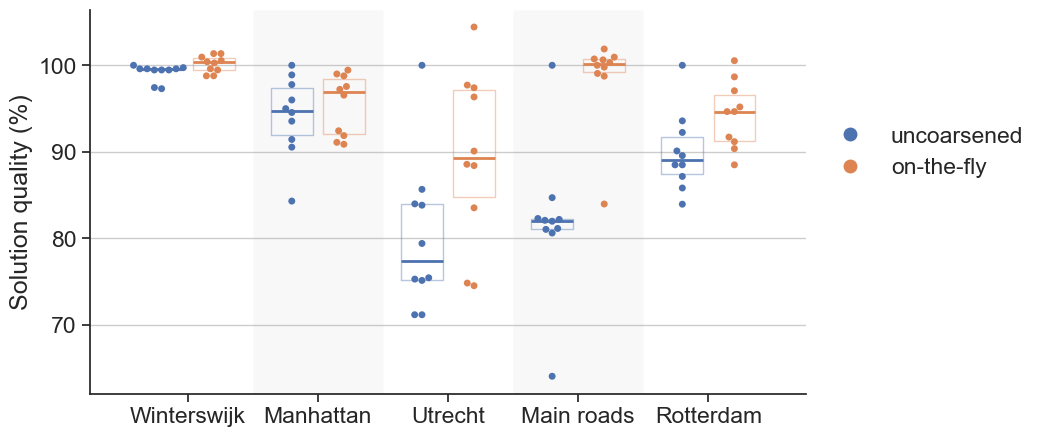

In [38]:
results_seedplot = pd.DataFrame()
for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
    results_seedplot_city = pd.DataFrame()
    results_seedplot_city['Solution quality (%)'] = (
        results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']/
        max(results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']))*100 # nfe_of_best
    results_seedplot_city['NFE to search stall'] = results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['nfe_of_best']
    results_seedplot_city['city'] = city
    results_seedplot_city['algo'] = 'uncoarsened'
    results_seedplot = pd.concat([results_seedplot, results_seedplot_city])
    
    results_seedplot_city_ = pd.DataFrame()
    results_seedplot_city_['Solution quality (%)'] = (
        (results_best_onthefly.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']/1000)/
        max(results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']))*100 # nfe_of_best
    results_seedplot_city_['NFE to search stall'] = results_best_onthefly.query(f'SSR == "without_SSR" & city == "{city}"')['nfe_of_best']
    results_seedplot_city_['city'] = city
    results_seedplot_city_['algo'] = 'on-the-fly'
    results_seedplot = pd.concat([results_seedplot, results_seedplot_city_])
    
results_seedplot
# plots (from paper3) (solqual + nfe)


sns.set_style("ticks")
sns.catplot(results_seedplot, y='Solution quality (%)', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)

ax = sns.swarmplot(data=results_seedplot, y='Solution quality (%)', x = 'city', hue='algo', dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), markerscale=2, frameon=False)  

# g.map(sns.catplot(results, y='best_score', x = '|U|, |S|', hue='approach', palette=my_palette, kind='swarm', dodge=True, ))
# ww: 2.6, mh: 1.8
# plt.ylim(58, 103)
ax.set(xlabel='')
for x in range(0, len(results_seedplot['city'].unique())):
    plt.axvspan(x - 0.5, x + 0.5, facecolor='gray', alpha=[0 if x%2 == 0 else 0.05][0])
ax.grid(axis='y')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:], labels=labels[:])
ax.legend_.set_title(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), frameon=False)   # , markerscale=2

plt.xticks(range(5), ['Winterswijk', 'Manhattan', 'Utrecht', 'Main roads', 'Rotterdam'])

plt.savefig(f'figs/onthefly_score_swarmplot.png', dpi=300, bbox_inches='tight')

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_27276\3067539330.py:2: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.catplot(results_seedplot, y='NFE to search stall', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)


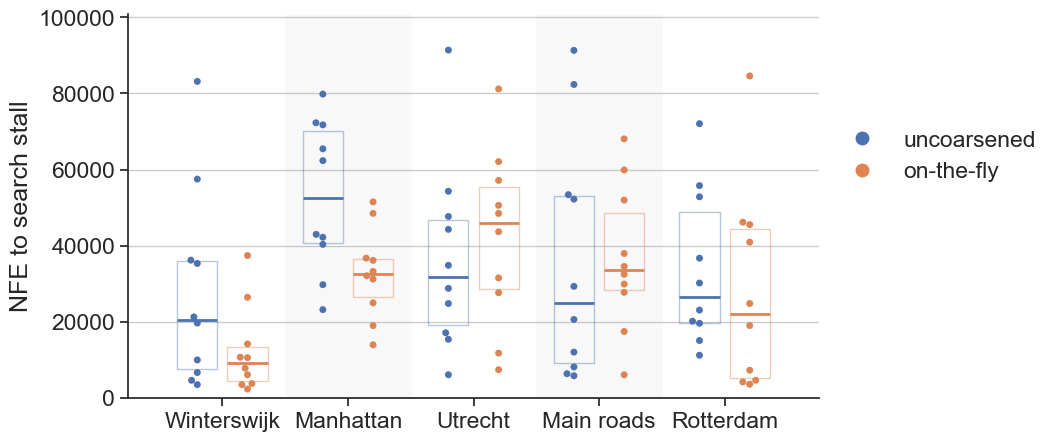

In [39]:
sns.set_style("ticks")
sns.catplot(results_seedplot, y='NFE to search stall', x = 'city', hue='algo', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)

ax = sns.swarmplot(data=results_seedplot, y='NFE to search stall', x = 'city', hue='algo', dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), markerscale=2, frameon=False)  

plt.ylim(0, 101000)
ax.set(xlabel='')
for x in range(0, len(results_seedplot['city'].unique())):
    plt.axvspan(x - 0.5, x + 0.5, facecolor='gray', alpha=[0 if x%2 == 0 else 0.05][0])
ax.grid(axis='y')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:], labels=labels[:])
ax.legend_.set_title(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), frameon=False)   # , markerscale=2

plt.xticks(range(5), ['Winterswijk', 'Manhattan', 'Utrecht', 'Main roads', 'Rotterdam'])

plt.savefig(f'figs/onthefly_nfe_swarmplot.png', dpi=300, bbox_inches='tight')

In [53]:
results_best_orig

,SSR,city,num nodes,node reduction (%),cross eval score,% of original score,seed,best_score,nfe_of_best,time_to_best,approach,earliest_nfe_of_95,Percentage of routes intercepted
0,without_SSR,Winterswijk,1926,0.0,0.737,100,0,737.0,6615,13.999901,original,3443,73.7
0,without_SSR,Winterswijk,1926,0.0,0.740,100,1,740.0,57472,121.633001,original,3443,74.0
0,without_SSR,Winterswijk,1926,0.0,0.737,100,2,737.0,21241,44.954179,original,3443,73.7
0,without_SSR,Winterswijk,1926,0.0,0.736,100,3,736.0,19626,41.536214,original,3443,73.6
0,without_SSR,Winterswijk,1926,0.0,0.736,100,4,736.0,35296,74.700000,original,3443,73.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,with_SSR,Rotterdam,7108,0.0,0.386,100,5,386.0,38886,512.223676,original,6662,38.6
0,with_SSR,Rotterdam,7108,0.0,0.359,100,6,359.0,22991,302.847671,original,6662,35.9
0,with_SSR,Rotterdam,7108,0.0,0.362,100,7,362.0,31744,418.146078,original,6662,36.2
0,with_SSR,Rotterdam,7108,0.0,0.390,100,8,390.0,63254,833.209803,original,6662,39.0


C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\2667278358.py:26: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.catplot(results_seedplot, y='Solution quality (%)', x = 'city', hue='SSR', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)


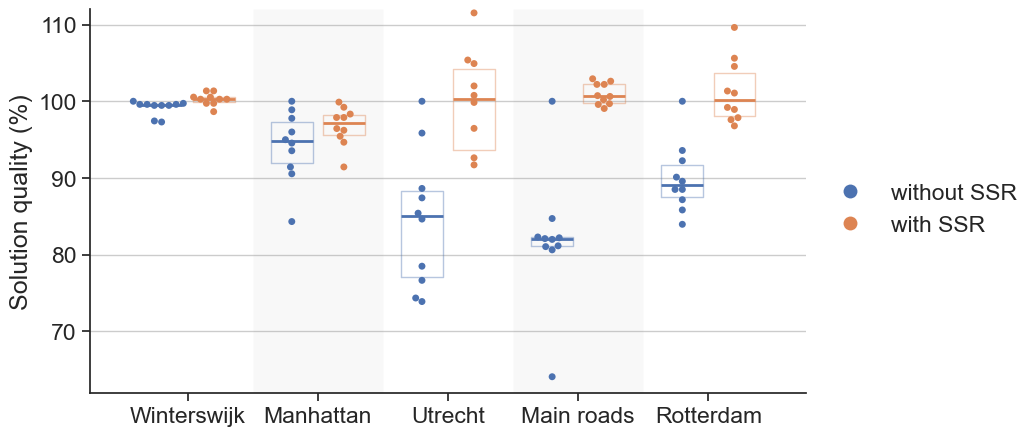

In [66]:
results_seedplot = pd.DataFrame()
for city in ['Winterswijk', 'Manhattan', 'Utrecht', 'Amsterdam', 'Rotterdam']:
    results_seedplot_city = pd.DataFrame()
    results_seedplot_city['Solution quality (%)'] = (
        results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']/
        max(results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']))*100 # nfe_of_best
    results_seedplot_city['NFE to search stall'] = results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['nfe_of_best']
    results_seedplot_city['city'] = city
    results_seedplot_city['SSR'] = 'without SSR'
    results_seedplot = pd.concat([results_seedplot, results_seedplot_city])
    
    results_seedplot_city_ = pd.DataFrame()
    results_seedplot_city_['Solution quality (%)'] = (
        (results_best_pruning.query(f'SSR == "with_SSR" & city == "{city}"')['cross eval score'])/
        max(results_best_orig.query(f'SSR == "without_SSR" & city == "{city}"')['cross eval score']))*100 # nfe_of_best
    results_seedplot_city_['NFE to search stall'] = results_best_pruning.query(f'SSR == "with_SSR" & city == "{city}"')['nfe_of_best']
    results_seedplot_city_['city'] = city
    results_seedplot_city_['SSR'] = 'with SSR'
    results_seedplot = pd.concat([results_seedplot, results_seedplot_city_])
    
results_seedplot
# plots (from paper3) (solqual + nfe)


sns.set_style("ticks")
sns.catplot(results_seedplot, y='Solution quality (%)', x = 'city', hue='SSR', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)

ax = sns.swarmplot(data=results_seedplot, y='Solution quality (%)', x = 'city', hue='SSR', dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), markerscale=2, frameon=False)  

# g.map(sns.catplot(results, y='best_score', x = '|U|, |S|', hue='approach', palette=my_palette, kind='swarm', dodge=True, ))
# ww: 2.6, mh: 1.8
plt.ylim(62, 112)
ax.set(xlabel='')
for x in range(0, len(results_seedplot['city'].unique())):
    plt.axvspan(x - 0.5, x + 0.5, facecolor='gray', alpha=[0 if x%2 == 0 else 0.05][0])
ax.grid(axis='y')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:], labels=labels[:])
ax.legend_.set_title(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.6), frameon=False)   # , markerscale=2

plt.xticks(range(5), ['Winterswijk', 'Manhattan', 'Utrecht', 'Main roads', 'Rotterdam'])

plt.savefig(f'figs/SSR_score_swarmplot.png', dpi=300, bbox_inches='tight')

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9724\3057467332.py:2: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.catplot(results_seedplot, y='NFE to search stall', x = 'city', hue='SSR', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)


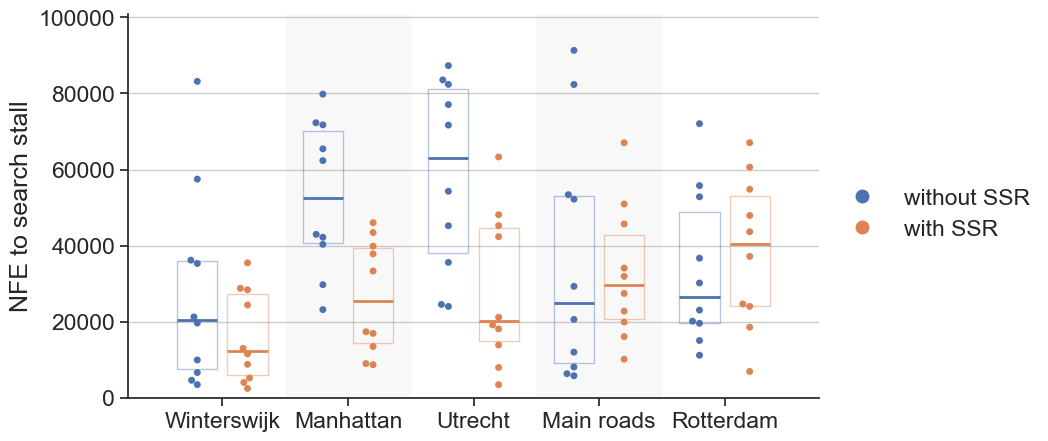

In [67]:
sns.set_style("ticks")
sns.catplot(results_seedplot, y='NFE to search stall', x = 'city', hue='SSR', kind='box', linewidth=1, boxprops={'alpha': 0.4}, gap=.2, aspect=1.7, whis=0, showfliers=False, linecolor='gray', showcaps = False, fill=False, medianprops=dict(linewidth=2), legend=False)

ax = sns.swarmplot(data=results_seedplot, y='NFE to search stall', x = 'city', hue='SSR', dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.75), markerscale=2, frameon=False)  

plt.ylim(0, 101000)
ax.set(xlabel='')
for x in range(0, len(results_seedplot['city'].unique())):
    plt.axvspan(x - 0.5, x + 0.5, facecolor='gray', alpha=[0 if x%2 == 0 else 0.05][0])
ax.grid(axis='y')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[:], labels=labels[:])
ax.legend_.set_title(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.6), frameon=False)   # , markerscale=2

plt.xticks(range(5), ['Winterswijk', 'Manhattan', 'Utrecht', 'Main roads', 'Rotterdam'])

plt.savefig(f'figs/SSR_nfe_swarmplot.png', dpi=300, bbox_inches='tight')